In [1]:
import pandas as pd
import pickle
from pathlib import Path
import os
import pandas as pd
import scanpy as sc
import cellink as cl
from cellink.tl._burden_testing import *

/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Combine all results and do FDR correction

In [2]:
chr1_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr1_all_results.pkl")
chr2_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr2_all_results.pkl")
chr3_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr3_all_results.pkl")
chr4_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr4_all_results.pkl")
chr5_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr5_all_results.pkl")
chr6_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr6_all_results.pkl")
chr7_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr7_all_results.pkl")
chr8_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr8_all_results.pkl")
chr9_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr9_all_results.pkl")
chr10_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr10_all_results.pkl")
chr11_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr11_all_results.pkl")
chr12_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr12_all_results.pkl")
chr13_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr13_all_results.pkl")
chr14_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr14_all_results.pkl")
chr15_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr15_all_results.pkl")
chr16_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr16_all_results.pkl")
chr17_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr17_all_results.pkl")
chr18_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr18_all_results.pkl")
chr19_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr19_all_results.pkl")
chr20_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr20_all_results.pkl")
chr21_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr21_all_results.pkl")
chr22_all_results=pd.read_pickle("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/chr22_all_results.pkl")


In [3]:
all_results = pd.concat([chr1_all_results, 
                    chr2_all_results,
                   chr3_all_results,
                   chr4_all_results,
                   chr5_all_results,
                    chr6_all_results, 
                    chr7_all_results,
                   chr8_all_results,
                   chr9_all_results,
                   chr10_all_results,
                    chr11_all_results,
                   chr12_all_results,
                   chr13_all_results,
                    chr14_all_results, 
                    chr15_all_results,
                   chr16_all_results,
                   chr17_all_results,
                   chr18_all_results,
                   chr19_all_results,
                   chr20_all_results,
                   chr21_all_results,
                   chr22_all_results,], ignore_index=True)

### correcting p values

In [2]:
from statsmodels.stats.multitest import multipletests
def FDR_correction(association_results):
    """
    association_results: pd.DataFrame, results from burden_test/ output written in run_burden_ass.py
    
    returns: - df_final: pd.DataFrame, association_results, sorted by celltype and burden type
                                        added column "FDR corrected" values and "significant"
             - df_to_plot: pd.DataFrame, summary of # significant egenes per cell type and burden type
    """
   
    df=association_results.copy()
    df_to_plot = pd.DataFrame(columns=['celltype', 'annotation', 'n'])
    
    df_final=[]
    for celltype in df["cell_type"].unique():
        df_annotations={}
        for annotation in df["burden_type"].unique():
            df_annotations[annotation] = df[(df["cell_type"] == celltype) & (df["burden_type"]==annotation)]
            df_annotations[annotation] = df_annotations[annotation].dropna(how='all')
            # FDR correction
            df_annotations[annotation]["significant"], df_annotations[annotation]["FDR_corrected"], _, _ = multipletests(df_annotations[annotation]["pvalue"], alpha=0.05, method='fdr_bh')
            
            df_to_plot = pd.concat([df_to_plot, pd.DataFrame({
                    'celltype': [celltype],
                    'annotation': [annotation],
                    'n': [len(df_annotations[annotation][df_annotations[annotation]["significant"]])]
                })], ignore_index=True)
            df_annotations[annotation]["celltype-annotation"]= f"{celltype}-{annotation}"
            df_final.append(df_annotations[annotation]) 
            
    df_final=pd.concat(df_final)
    
    df_to_plot['celltype_annotation'] = df_to_plot['celltype'] + "_" + df_to_plot['annotation']
    df_to_plot
    return df_final, df_to_plot

from plotnine import *
def plot_egenes(df_to_plot):
    """
    df_to_plot: pd.DataFrame, as output[1] of  FDR_correction()
    returns: plot, grouped barplot # egenes per cell type and burden
    """
    zero_types = list(df_to_plot.query("n==0")["celltype_annotation"])
    #Filter out the rows where `n` is 0 and create the plot
    plot = (
        ggplot(df_to_plot.query("celltype_annotation not in @zero_types"), 
               aes(x='celltype', y='n', fill='annotation'))  # Specify x, y, and fill variables
        + geom_bar(stat="identity", position="dodge")  # Use position="dodge" for grouped bars
        + theme_classic()  # Optional: use a clean theme
        + theme(
            axis_text_x=element_text(angle=45, hjust=1, vjust=1),
            figure_size=(7, 4)
        )
        + labs(
            y="Number of E-Genes", 
            x="", 
            fill="Burden Annotation"
        )
    )
    
    return(plot)


In [5]:
df_final, df_to_plot = FDR_correction(all_results)

In [25]:
df_final_1, df_to_plot_1 = FDR_correction(chr1_all_results)
df_final_2, df_to_plot_2 = FDR_correction(chr2_all_results)
df_final_3, df_to_plot_3 = FDR_correction(chr3_all_results)
df_final_4, df_to_plot_4 = FDR_correction(chr4_all_results)
df_final_5, df_to_plot_5 = FDR_correction(chr5_all_results)
df_final_6, df_to_plot_6 = FDR_correction(chr6_all_results)
df_final_7, df_to_plot_7 = FDR_correction(chr7_all_results)
df_final_8, df_to_plot_8 = FDR_correction(chr8_all_results)
df_final_9, df_to_plot_9 = FDR_correction(chr9_all_results)
df_final_10, df_to_plot_10 = FDR_correction(chr10_all_results)
df_final_11, df_to_plot_11 = FDR_correction(chr11_all_results)
df_final_12, df_to_plot_12 = FDR_correction(chr12_all_results)
df_final_13, df_to_plot_13 = FDR_correction(chr13_all_results)

df_final_14, df_to_plot_14 = FDR_correction(chr14_all_results)
df_final_15, df_to_plot_15 = FDR_correction(chr15_all_results)
df_final_16, df_to_plot_16 = FDR_correction(chr16_all_results)
df_final_17, df_to_plot_17 = FDR_correction(chr17_all_results)
df_final_18, df_to_plot_18 = FDR_correction(chr18_all_results)
df_final_19, df_to_plot_19 = FDR_correction(chr19_all_results)
df_final_20, df_to_plot_20 = FDR_correction(chr20_all_results)
df_final_21, df_to_plot_21 = FDR_correction(chr21_all_results)
df_final_22, df_to_plot_22 = FDR_correction(chr22_all_results)

In [26]:
all_results = pd.concat([chr1_all_results, 
                    chr2_all_results,
                   chr3_all_results,
                   chr4_all_results,
                   chr5_all_results,
                    chr6_all_results, 
                    chr7_all_results,
                   chr8_all_results,
                   chr9_all_results,
                   chr10_all_results,
                    chr11_all_results,
                   chr12_all_results,
                   chr13_all_results,
                    chr14_all_results, 
                    chr15_all_results,
                   chr16_all_results,
                   chr17_all_results,
                   chr18_all_results,
                   chr19_all_results,
                   chr20_all_results,
                   chr21_all_results,
                   chr22_all_results,], ignore_index=True)

In [30]:
all_results.to_csv('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/all_results.csv', index=False) 

In [27]:
df_final, df_to_plot = FDR_correction(all_results)

In [31]:
df_final.to_csv('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/all_results_FDR_corrected.csv', index=False) 


In [41]:
df_to_plot_filtered =df_to_plot[~df_to_plot["celltype"].isin(["Erythrocytes", "Platelets"])]

In [32]:
df_to_plot.to_csv('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/all_results_summary.csv', index=False) 

[2025-01-30 08:58:23,643] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


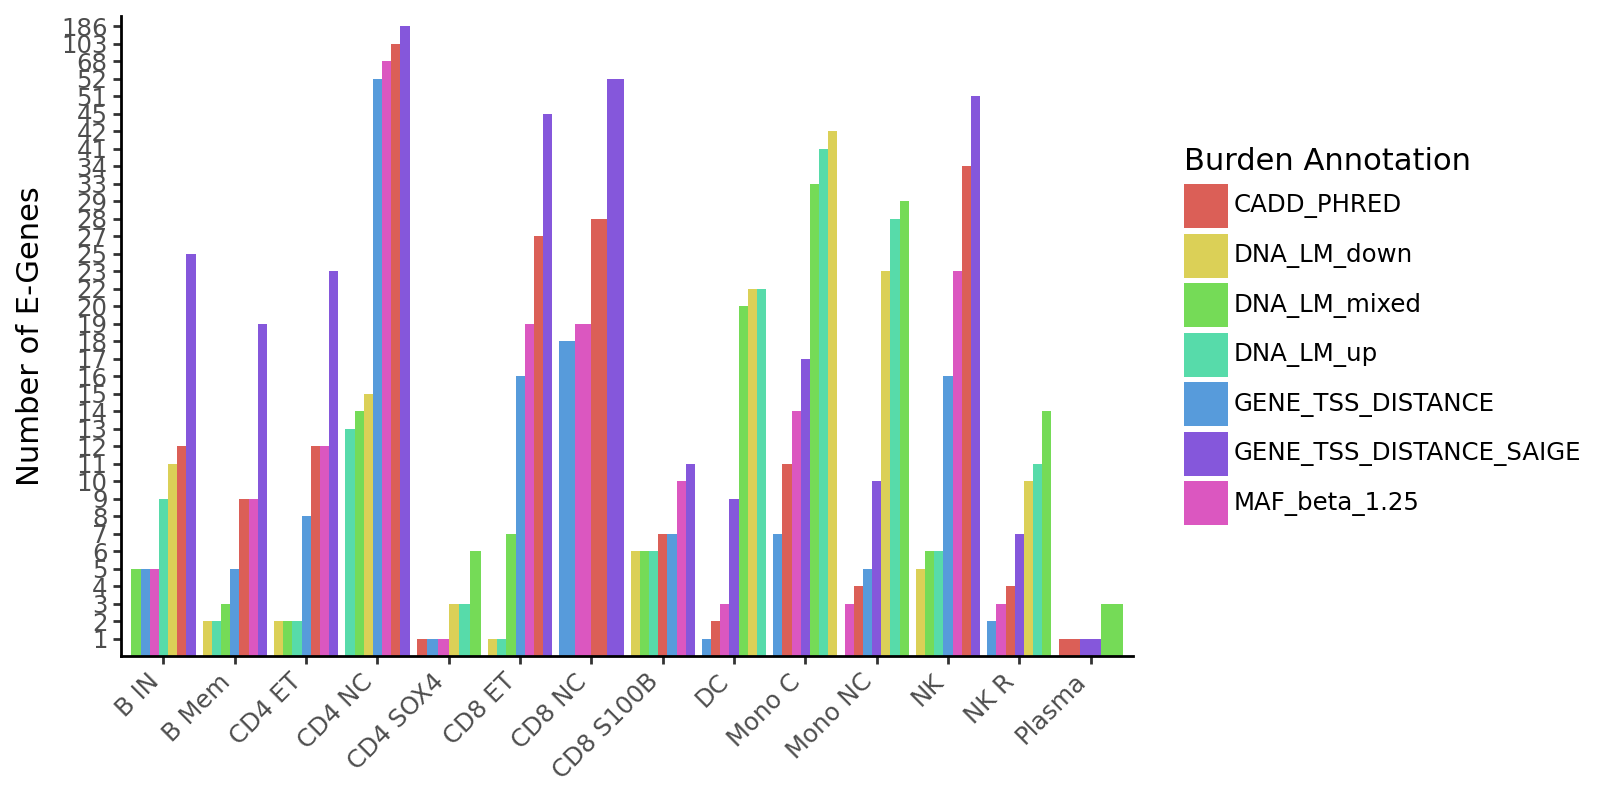

In [6]:
test=df_to_plot[~df_to_plot["celltype"].isin(["Erythrocytes", "Platelets"])]
plot_egenes(test)

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_egenes_seaborn(df_to_plot):
    """
    df_to_plot: pd.DataFrame, as output[1] of FDR_correction()
    returns: seaborn grouped barplot # egenes per cell type and burden
    """
    # Filter out rows where `n` is 0
    df_filtered = df_to_plot[df_to_plot["n"] > 0]

    # Set figure size
    plt.figure(figsize=(10, 5))

    # Create grouped barplot
    sns.barplot(
        data=df_filtered,
        x="celltype",
        y="n",
        hue="annotation",
        dodge=True  # Ensures bars are grouped correctly
    )

    # Adjust labels and title
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("")
    plt.ylabel("Number of E-Genes")
    plt.title("E-Genes per Cell Type and Burden")
    plt.legend(title="Burden Annotation")

    # Show the plot
    plt.show()

from matplotlib.ticker import MaxNLocator


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

def plot_egenes_with_broken_axis(df_to_plot):
    #plt.rcParams.update({'font.size': 14})
    plt.rcParams.update({'font.size': 16})
    # Filter out rows where `n` is 0
    df_filtered = df_to_plot[df_to_plot["n"] > 0]

    df_filtered["celltype"] = pd.Categorical(df_filtered["celltype"], categories=sorted(df_filtered["celltype"].unique()), ordered=True)
    df_filtered["annotation"] = pd.Categorical(df_filtered["annotation"], categories=sorted(df_filtered["annotation"].unique()), ordered=True)

    # Sort the DataFrame by the specified order
    df_filtered = df_filtered.sort_values(by=["celltype", "annotation"])


    # Create figure and two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 9]})
    
    # Set y-axis limits for the two axes
    upper_limit = 105
    lower_limit = 180

    # Upper part of the plot
    sns.barplot(data=df_filtered, x="celltype", y="n", hue="annotation", dodge=True, ax=ax1)
    ax1.set_ylim(lower_limit, 190)  # Set upper y-axis range
    ax1.spines["bottom"].set_visible(False)  # Hide bottom spine
    ax1.tick_params(bottom=False)  # Remove bottom ticks

    # Lower part of the plot
    sns.barplot(data=df_filtered, x="celltype", y="n", hue="annotation", dodge=True, ax=ax2)
    ax2.set_ylim(0, upper_limit)  # Set lower y-axis range
    ax2.spines["top"].set_visible(False)  # Hide top spine

    # Add diagonal lines to indicate the break in the y-axis
    d = 0.005  # Size of diagonal lines
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)  # Top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

    # ax2_ticks = ax2.get_yticks()  
    ax1.set_yticks([180, 190])
    ax2.set_yticks(range(0, 105, 10))
    #ax2.plot([], [], ' ', label="cut y-axis, GENE_TSS_DIST_SAIGE in CD4 NC: 186 eGenes")

    handles, labels = ax2.get_legend_handles_labels()

    # Find the index of "GENE_TSS_DISTANCE_SAIGE" and update its label
    index_to_update = labels.index("GENE_TSS_DISTANCE_SAIGE")
    labels[index_to_update] = "GENE_TSS_DISTANCE_SAIGE, \ncut y axis, 186 eGenes in CD4 NC"  # Replace with the new label text
    
    # Move "GENE_TSS_DISTANCE_SAIGE" to the bottom
    handles.append(handles.pop(index_to_update))
    labels.append(labels.pop(index_to_update))

    legend = ax2.legend(
        title="Burden Annotation", 
        handles=handles, 
        labels=labels, 
        #handles=[extra_text] + ax2.legend.legendHandles,  # Add extra text at the top
        loc='upper right',  # Place legend within the box
        fontsize=15,  # Increase font size
        title_fontsize=15  # Increase title font size
    )
    legend.set_frame_on(True)  # Add a box around the legend
    #legend.get_texts()[-1].set_fontsize(12)   # Set a smaller font size for the extra text
    #legend.get_texts()[-1].set_color("purple")  # Change text color to gray (or any color)

    # Add labels and legend
    ax1.set_xlabel("")
    ax2.set_xlabel("")
    ax2.set_ylabel("Number of significant E-Genes", fontsize=18)
    ax1.set_ylabel("")
    #ax1.legend(title="Burden Annotation", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.legend_.remove()
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")
    ax1.set_title("E-Genes per Cell Type and Burden Type")
    ax1.set_title("")

    # Adjust layout
    plt.tight_layout()
    plt.show()



/scratch/tmp/l_back/ipykernel_4140698/3282870390.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/tmp/l_back/ipykernel_4140698/3282870390.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/tmp/l_back/ipykernel_4140698/3282870390.py:119: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


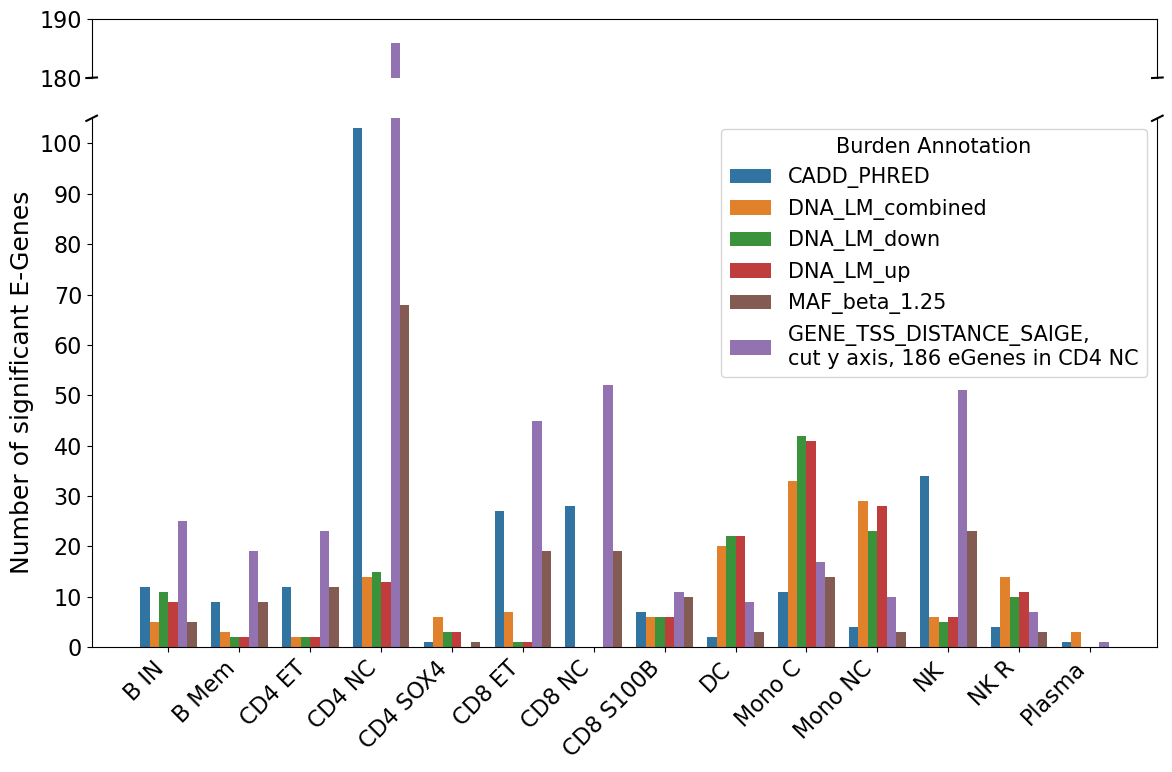

In [40]:
df_to_plot = pd.read_csv("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/all_results_summary_newest.csv")

df_to_plot_filtered =df_to_plot[(~df_to_plot["celltype"].isin(["Erythrocytes", "Platelets"])) &
                                (df_to_plot["annotation"]!="GENE_TSS_DISTANCE")]
df_to_plot_filtered.loc[df_to_plot_filtered["annotation"] == "DNA_LM_mixed", "annotation"] = "DNA_LM_combined"

# Example usage with df_to_plot
plot_egenes_with_broken_axis(df_to_plot_filtered)

/scratch/tmp/l_back/ipykernel_3282735/2317633003.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["celltype"] = pd.Categorical(df_filtered["celltype"], categories=sorted(df_filtered["celltype"].unique()), ordered=True)
/scratch/tmp/l_back/ipykernel_3282735/2317633003.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["annotation"] = pd.Categorical(df_filtered["annotation"], categories=sorted(df_filtered["annotation"].unique()), ordered=True)
/scratch/tmp/l_back/ipykernel_328273

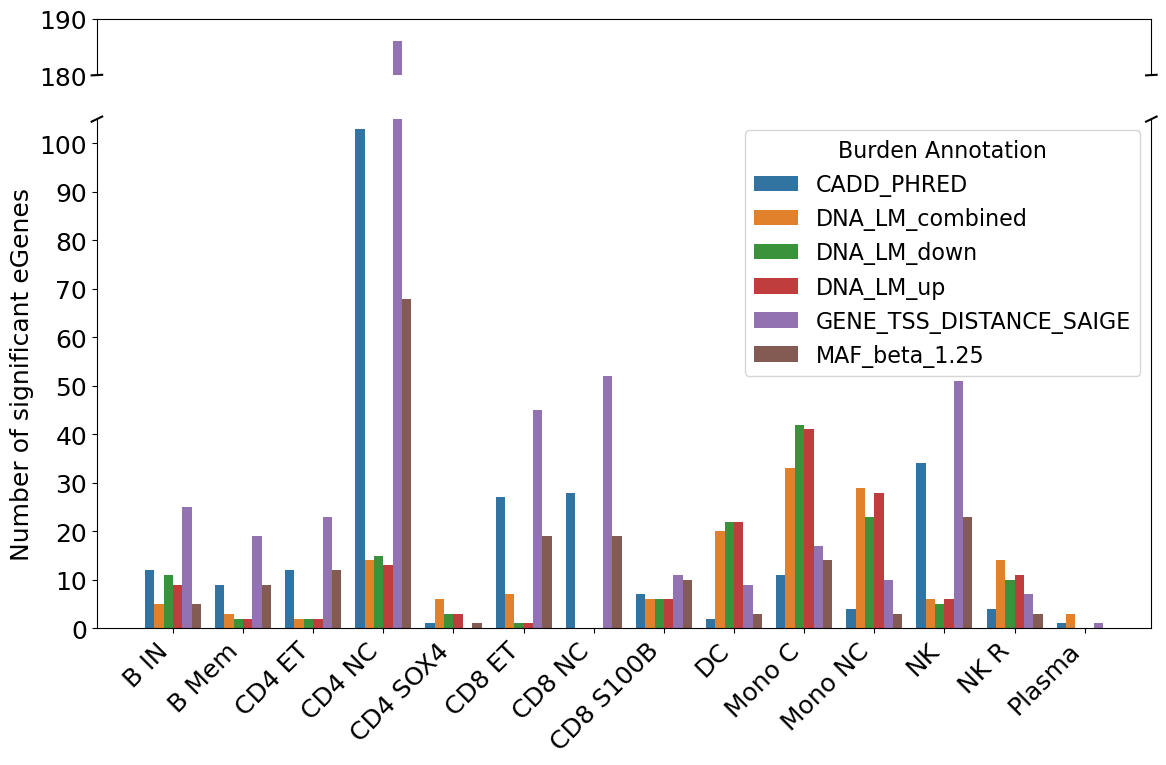

In [13]:
df_to_plot = pd.read_csv("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/all_results_summary_newest.csv")

df_to_plot_filtered =df_to_plot[(~df_to_plot["celltype"].isin(["Erythrocytes", "Platelets"])) &
                                (df_to_plot["annotation"]!="GENE_TSS_DISTANCE")]
df_to_plot_filtered.loc[df_to_plot_filtered["annotation"] == "DNA_LM_mixed", "annotation"] = "DNA_LM_combined"

# Example usage with df_to_plot
plot_egenes_with_broken_axis(df_to_plot_filtered)

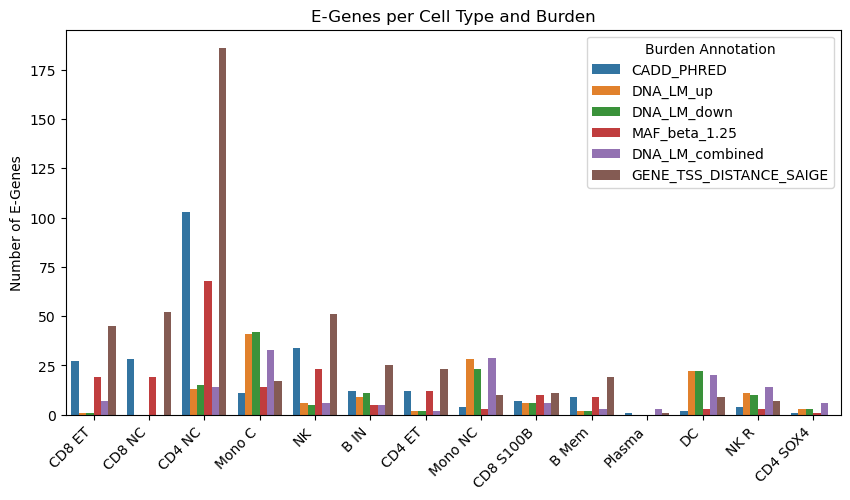

In [122]:
df_to_plot_filtered =df_to_plot[(~df_to_plot["celltype"].isin(["Erythrocytes", "Platelets"])) &
                                (df_to_plot["annotation"]!="GENE_TSS_DISTANCE")]
df_to_plot_filtered.loc[df_to_plot_filtered["annotation"] == "DNA_LM_mixed", "annotation"] = "DNA_LM_combined"

plot_egenes_seaborn(df_to_plot_filtered)

/scratch/tmp/l_back/ipykernel_2586627/1858580900.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/tmp/l_back/ipykernel_2586627/1858580900.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/tmp/l_back/ipykernel_2586627/1858580900.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


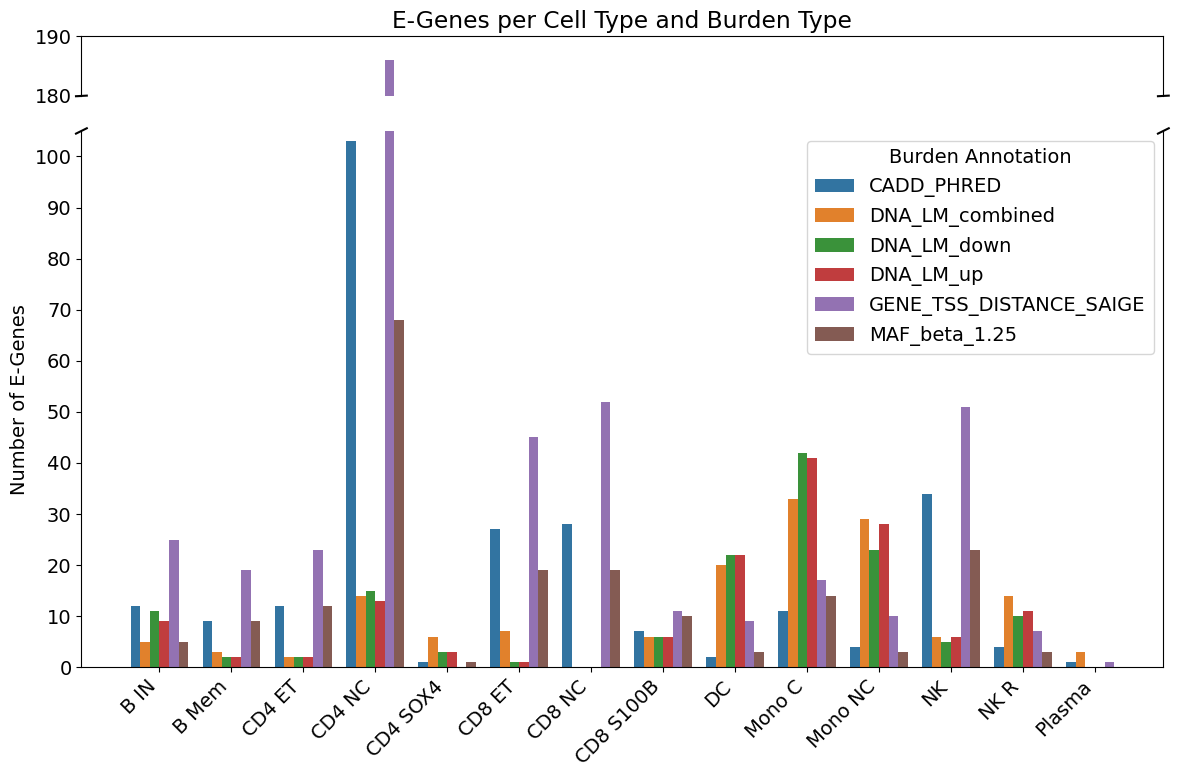

In [151]:
# Example usage with df_to_plot
plot_egenes_with_broken_axis(df_to_plot_filtered)

In [7]:
df_to_plot_filtered

celltype               annotation   n               celltype_annotation
0     CD8 ET               CADD_PHRED  27                 CD8 ET_CADD_PHRED
1     CD8 ET                DNA_LM_up   1                  CD8 ET_DNA_LM_up
2     CD8 ET              DNA_LM_down   1                CD8 ET_DNA_LM_down
3     CD8 ET            MAF_beta_1.25  19              CD8 ET_MAF_beta_1.25
4     CD8 ET          DNA_LM_combined   7            CD8 ET_DNA_LM_combined
..       ...                      ...  ..                               ...
85  CD4 SOX4                DNA_LM_up   3                CD4 SOX4_DNA_LM_up
86  CD4 SOX4              DNA_LM_down   3              CD4 SOX4_DNA_LM_down
87  CD4 SOX4            MAF_beta_1.25   1            CD4 SOX4_MAF_beta_1.25
88  CD4 SOX4          DNA_LM_combined   6          CD4 SOX4_DNA_LM_combined
89  CD4 SOX4  GENE_TSS_DISTANCE_SAIGE   0  CD4 SOX4_GENE_TSS_DISTANCE_SAIGE

[84 rows x 4 columns]

## per chromosome

[2025-01-28 14:55:03,275] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


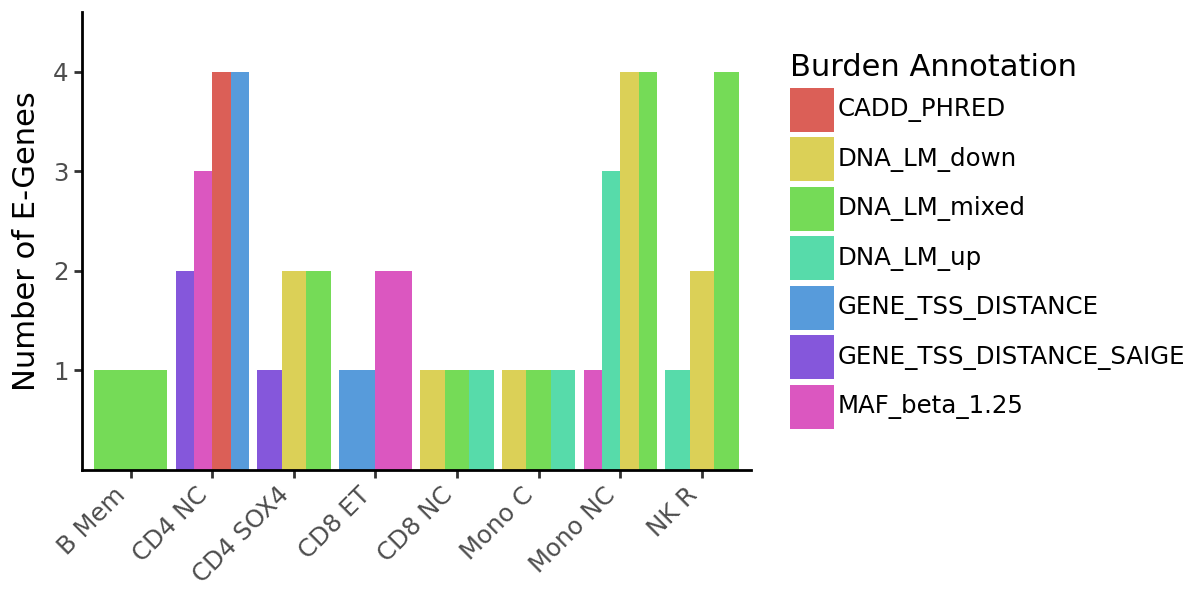

In [12]:
plot_egenes(df_to_plot_14)

[2025-01-28 14:55:16,524] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


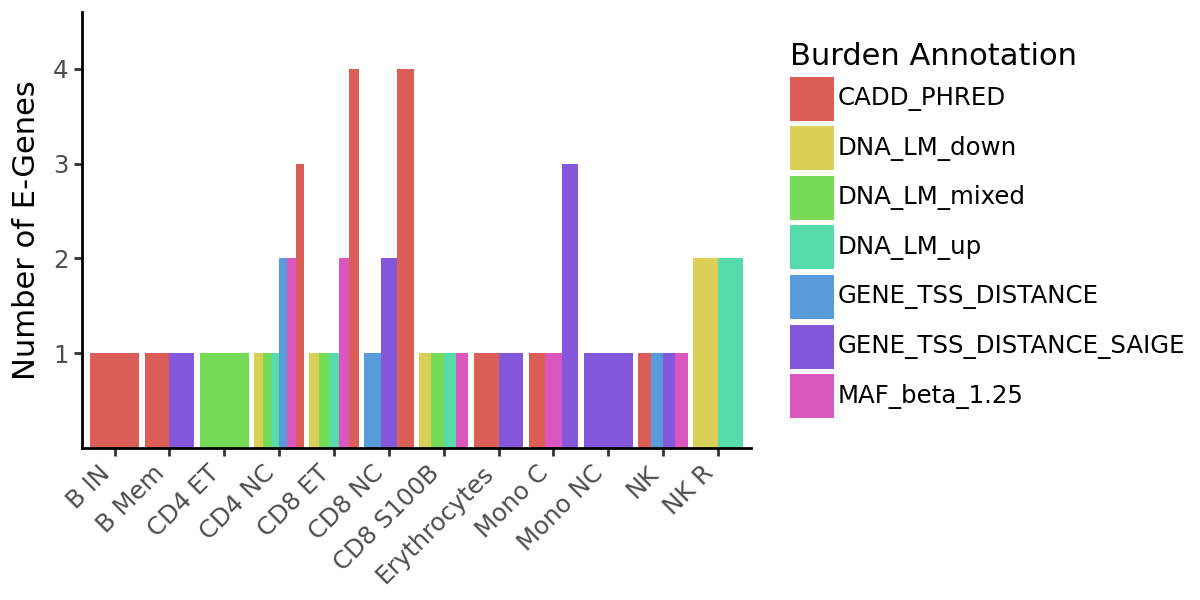

In [13]:
plot_egenes(df_to_plot_15)

[2025-01-28 14:57:27,730] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


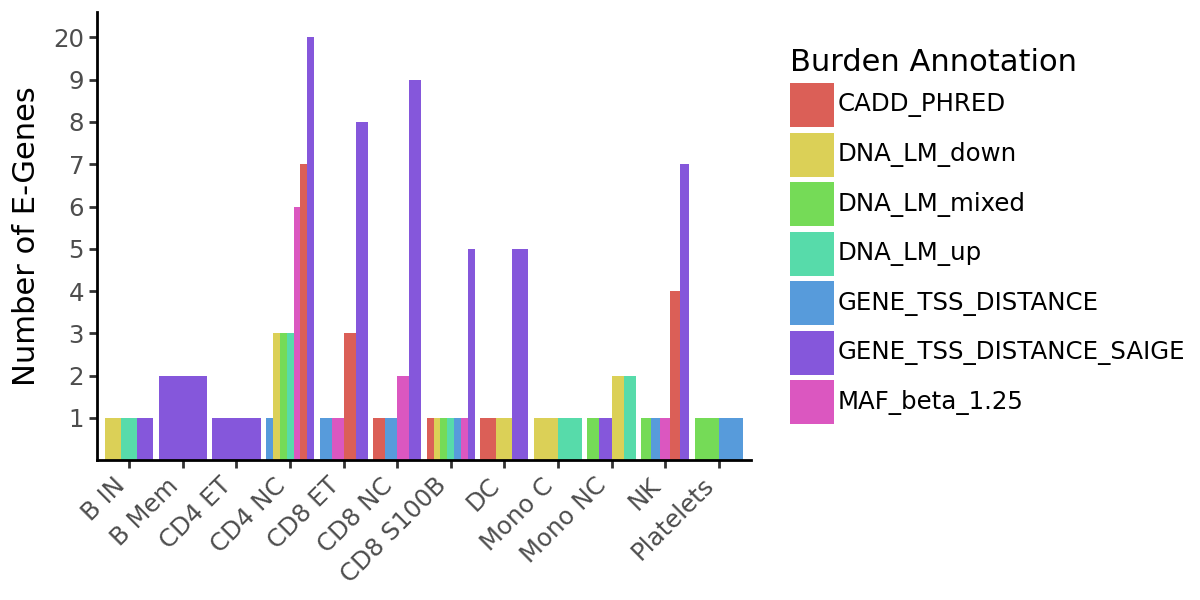

In [16]:
plot_egenes(df_to_plot_16)

[2025-01-28 14:57:44,481] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


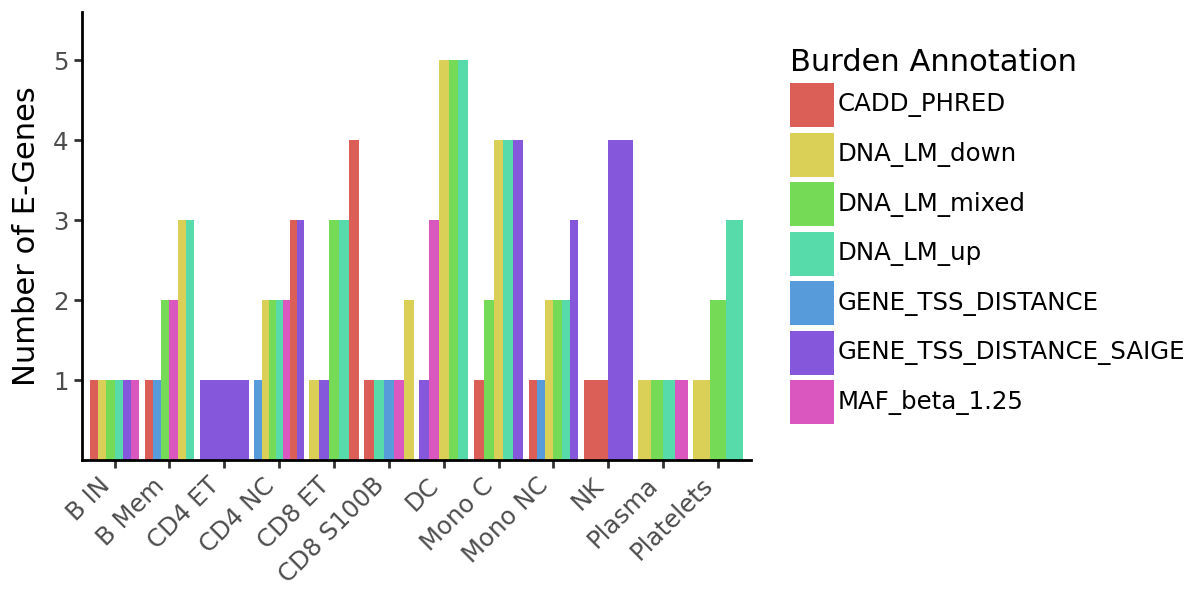

In [17]:
plot_egenes(df_to_plot_17)

In [18]:
df_to_plot_17

celltype               annotation  n               celltype_annotation
0      CD8 ET               CADD_PHRED  4                 CD8 ET_CADD_PHRED
1      CD8 ET                DNA_LM_up  3                  CD8 ET_DNA_LM_up
2      CD8 ET              DNA_LM_down  1                CD8 ET_DNA_LM_down
3      CD8 ET            MAF_beta_1.25  0              CD8 ET_MAF_beta_1.25
4      CD8 ET             DNA_LM_mixed  3               CD8 ET_DNA_LM_mixed
..        ...                      ... ..                               ...
100  CD4 SOX4              DNA_LM_down  0              CD4 SOX4_DNA_LM_down
101  CD4 SOX4            MAF_beta_1.25  0            CD4 SOX4_MAF_beta_1.25
102  CD4 SOX4             DNA_LM_mixed  0             CD4 SOX4_DNA_LM_mixed
103  CD4 SOX4        GENE_TSS_DISTANCE  0        CD4 SOX4_GENE_TSS_DISTANCE
104  CD4 SOX4  GENE_TSS_DISTANCE_SAIGE  0  CD4 SOX4_GENE_TSS_DISTANCE_SAIGE

[105 rows x 4 columns]

## QQ plots

In [32]:
def QQ_plot_sig_egenes(FDR_corrected_results, burdentype):
    """
    FDR_corrected_results: pd.DataFrame, output[0] of FDR_correction()
    burdentype: Str

    returns: QQ plot for given burden. Red line: uniform distributed pvalues. 
                                        in red: significant egens
    """
    df = FDR_corrected_results.copy().query("burden_type == @burdentype")

    df = df.sort_values("pvalue")
    df["-log10pval_expected"] = -np.log10(np.arange(1, len(df) + 1) / len(df))
    
    if "-log10pval" not in df.columns:
        df["-log10pval"] = -np.log10(df["pvalue"])
    
    aes_kwargs = dict(x="-log10pval_expected", y="-log10pval")
    plot = (
        ggplot(df, aes(**aes_kwargs, color="significant"))
        + labs(title=f"{burdentype}")
        + scale_color_manual(values = ["black", "red"])
        + theme_classic(base_size = 18)
        + geom_abline(intercept=0, slope=1, color="red")
        + geom_point()
        #+ theme(legend_position="top", figure_size = (5,5))
        + theme(
            legend_position="top", 
            figure_size=(5,5),
            #axis_title_size=18,  # Adjust axis title font size
            #axis_text_size=18,   # Adjust axis text font size
            #plot_title_size=18,  # Adjust title font size
            #legend_text_size=18  # Adjust legend text font size
        )
    )
    return(plot)

In [38]:
df_to_plot_filtered.loc[df_to_plot_filtered["annotation"] == "DNA_LM_mixed", "annotation"] = "DNA_LM_combined"
df_to_plot_filtered


celltype               annotation   n               celltype_annotation
0      CD8 ET               CADD_PHRED  27                 CD8 ET_CADD_PHRED
1      CD8 ET                DNA_LM_up   1                  CD8 ET_DNA_LM_up
2      CD8 ET              DNA_LM_down   1                CD8 ET_DNA_LM_down
3      CD8 ET            MAF_beta_1.25  19              CD8 ET_MAF_beta_1.25
4      CD8 ET          DNA_LM_combined   7               CD8 ET_DNA_LM_mixed
..        ...                      ...  ..                               ...
99   CD4 SOX4                DNA_LM_up   3                CD4 SOX4_DNA_LM_up
100  CD4 SOX4              DNA_LM_down   3              CD4 SOX4_DNA_LM_down
101  CD4 SOX4            MAF_beta_1.25   1            CD4 SOX4_MAF_beta_1.25
102  CD4 SOX4          DNA_LM_combined   6             CD4 SOX4_DNA_LM_mixed
104  CD4 SOX4  GENE_TSS_DISTANCE_SAIGE   0  CD4 SOX4_GENE_TSS_DISTANCE_SAIGE

[84 rows x 4 columns]

[2025-01-28 15:27:27,388] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


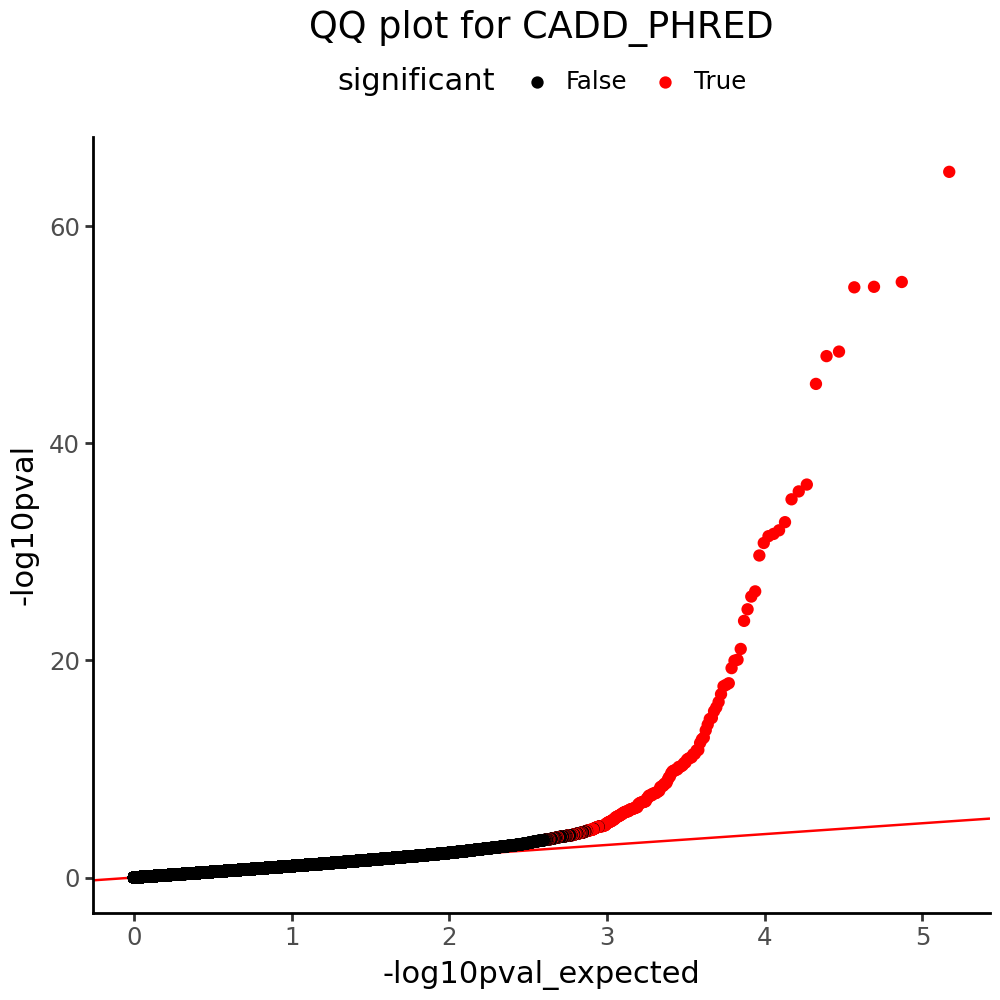

In [52]:
QQ_plot_sig_egenes(df_final, "CADD_PHRED")

[2025-01-28 15:27:01,398] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


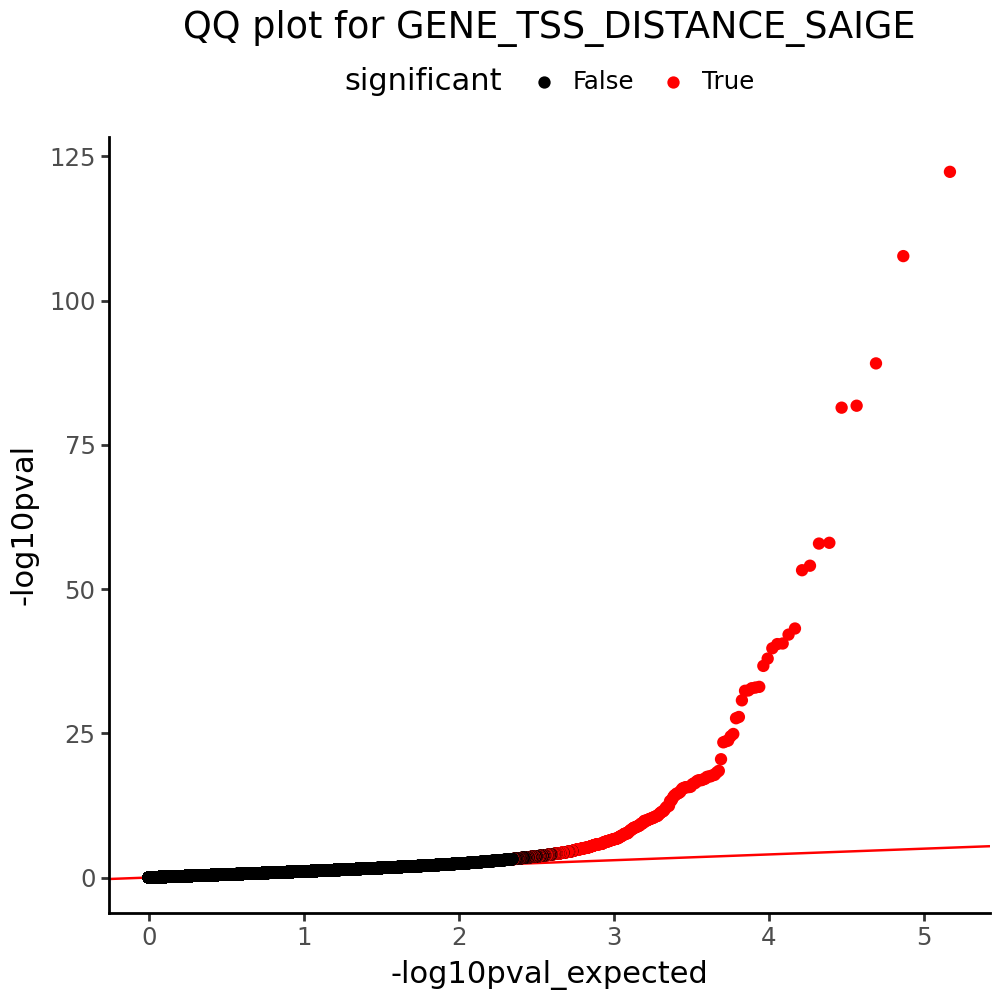

In [51]:
QQ_plot_sig_egenes(df_final, "GENE_TSS_DISTANCE_SAIGE")

[2025-01-28 15:27:32,736] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


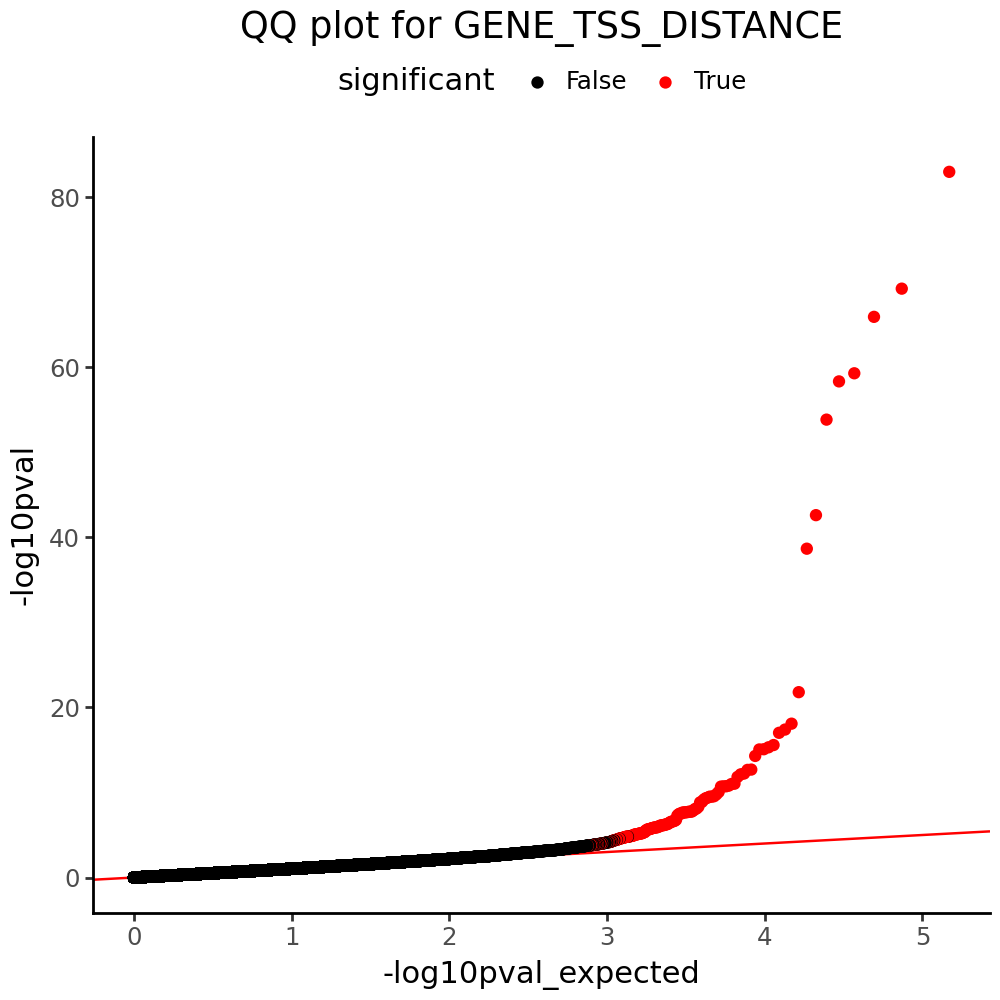

In [53]:
QQ_plot_sig_egenes(df_final, "GENE_TSS_DISTANCE")

[2025-01-28 15:28:52,413] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


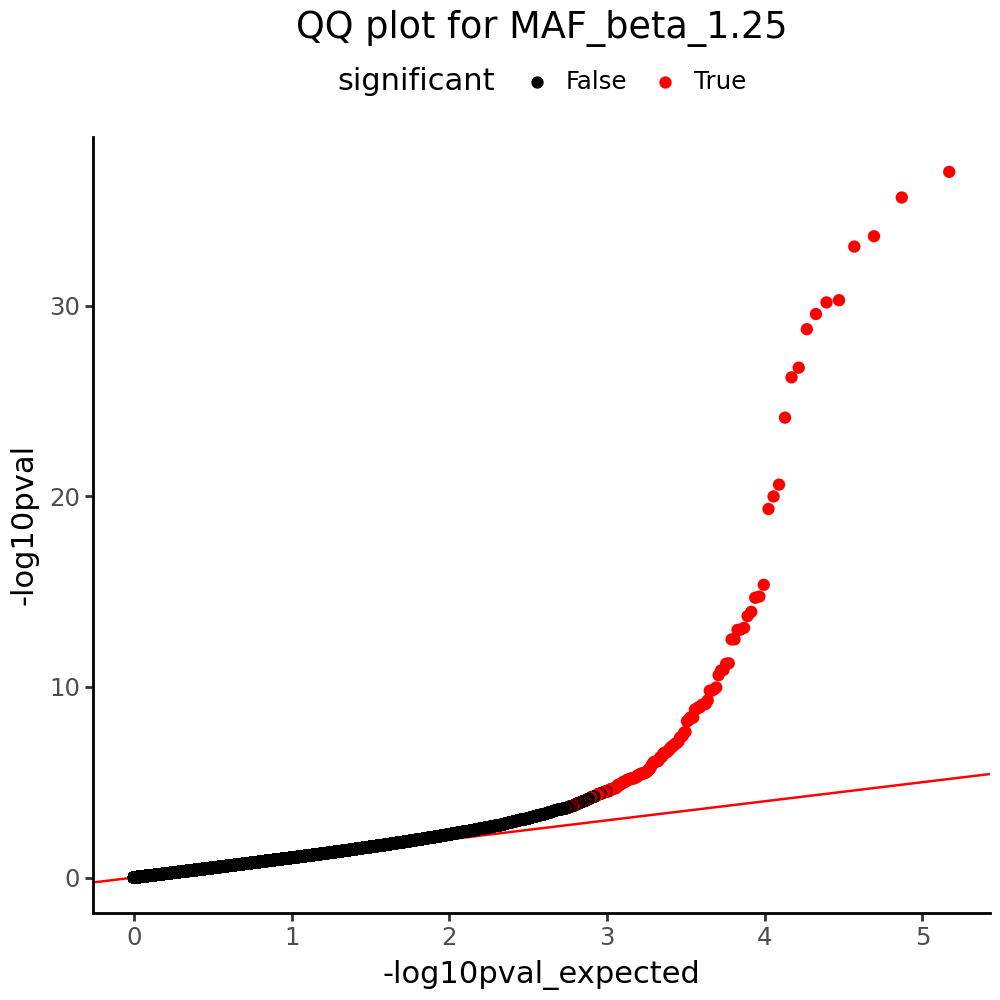

In [56]:
QQ_plot_sig_egenes(df_final, "MAF_beta_1.25")

[2025-01-28 15:29:38,401] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


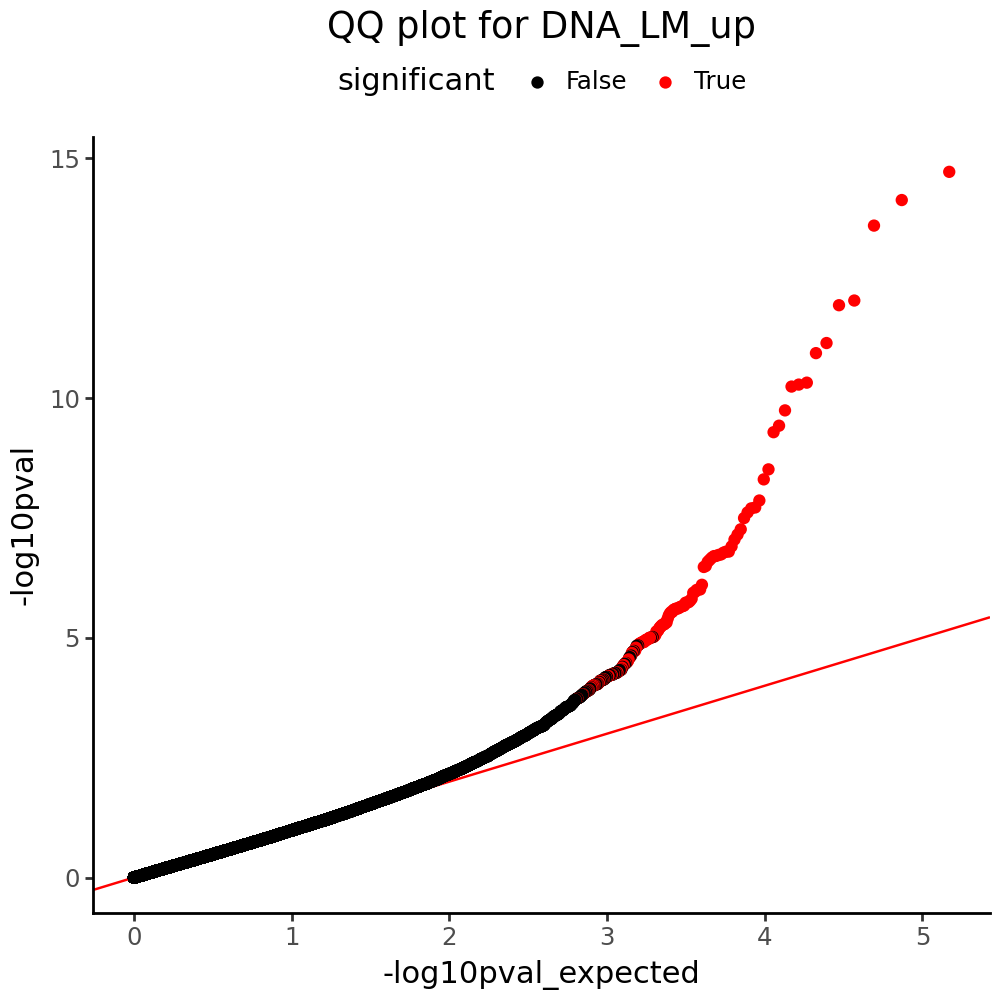

In [57]:
QQ_plot_sig_egenes(df_final, "DNA_LM_up")

[2025-01-28 15:30:14,123] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


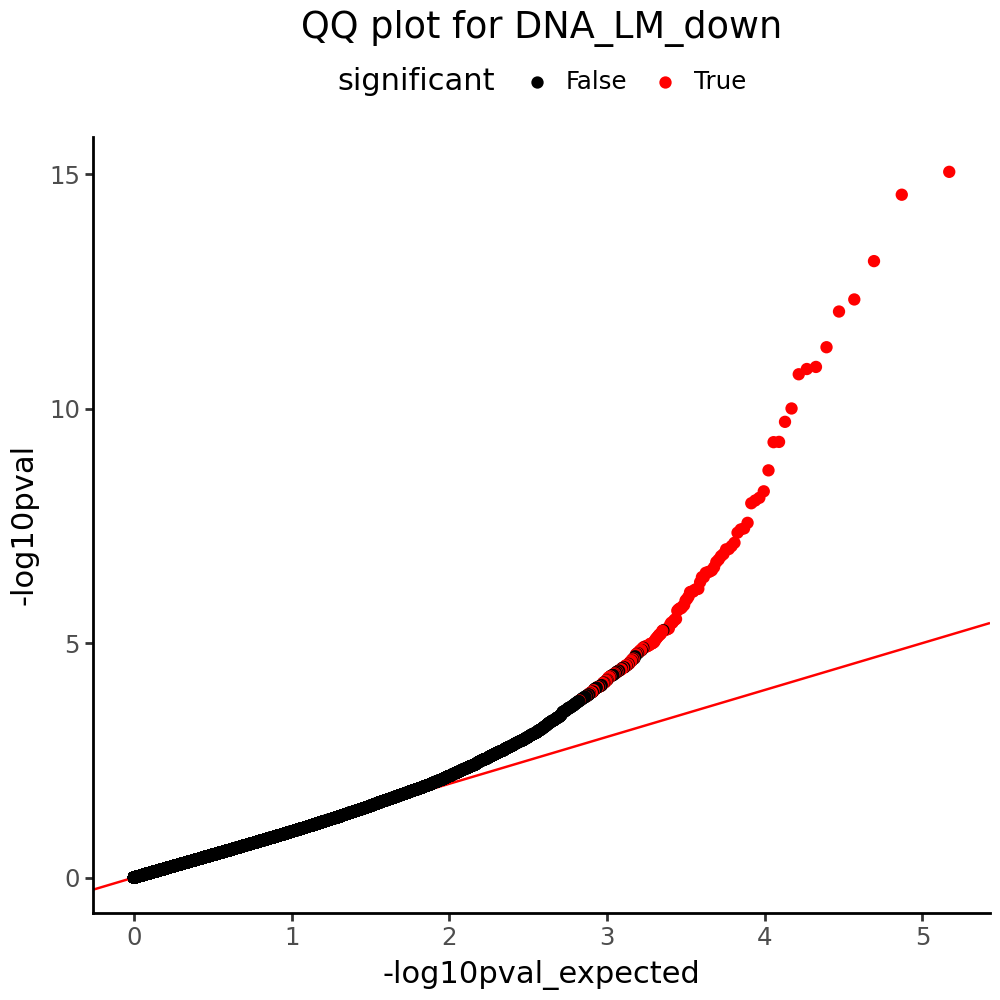

In [58]:
QQ_plot_sig_egenes(df_final, "DNA_LM_down")

[2025-01-28 15:30:53,732] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


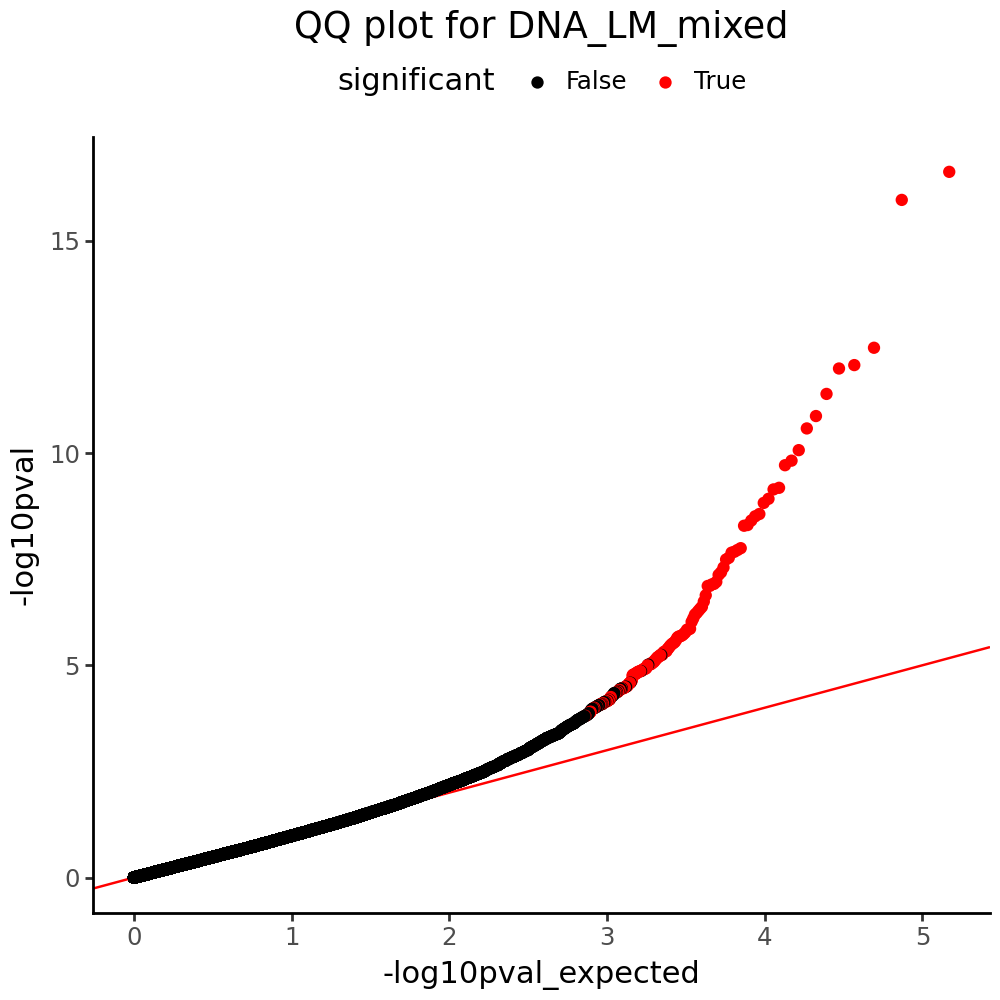

In [59]:
QQ_plot_sig_egenes(df_final, "DNA_LM_mixed")

In [8]:
df_final_comb=pd.read_csv("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association2/all_results_FDR_comb.csv")



[2025-01-30 10:12:09,937] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


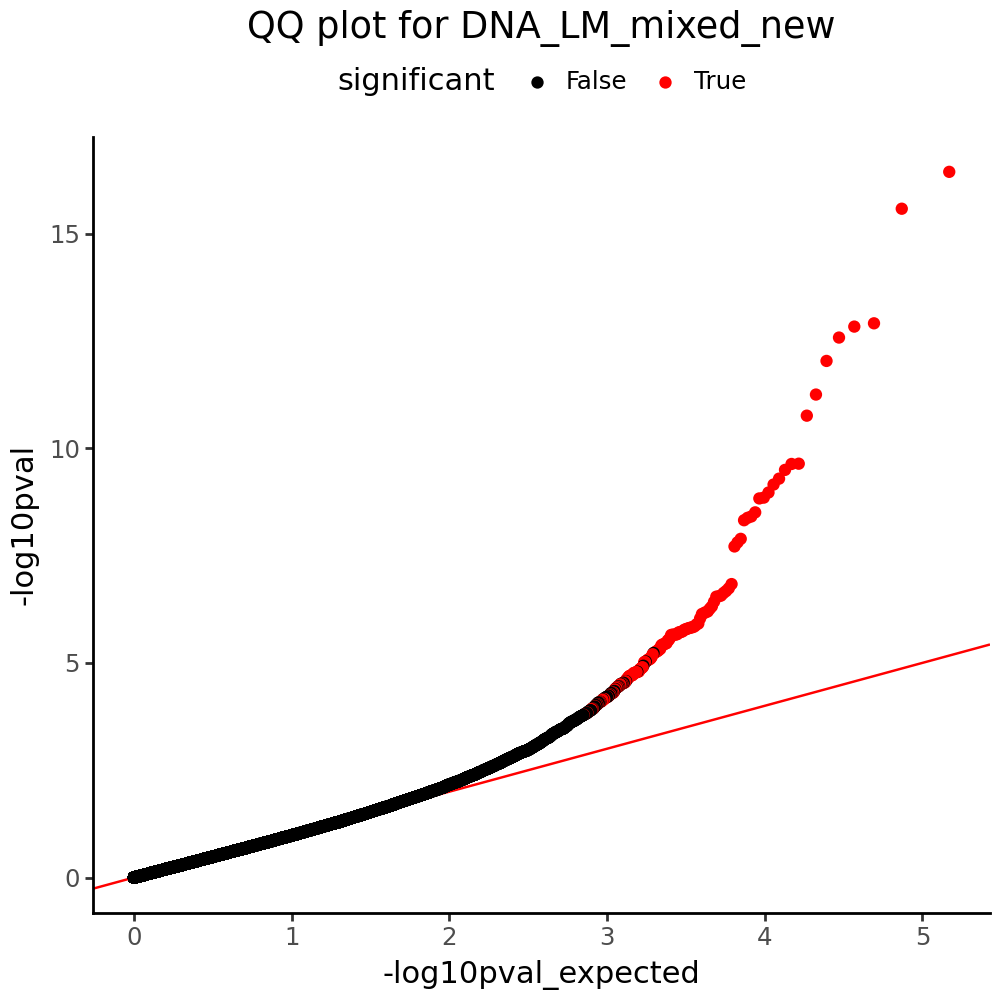

In [11]:
QQ_plot_sig_egenes(df_final_comb, "DNA_LM_mixed_new")

In [17]:
df_final=pd.read_csv('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/all_results_FDR_corrected_newest.csv') 


[2025-01-30 18:24:05,151] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


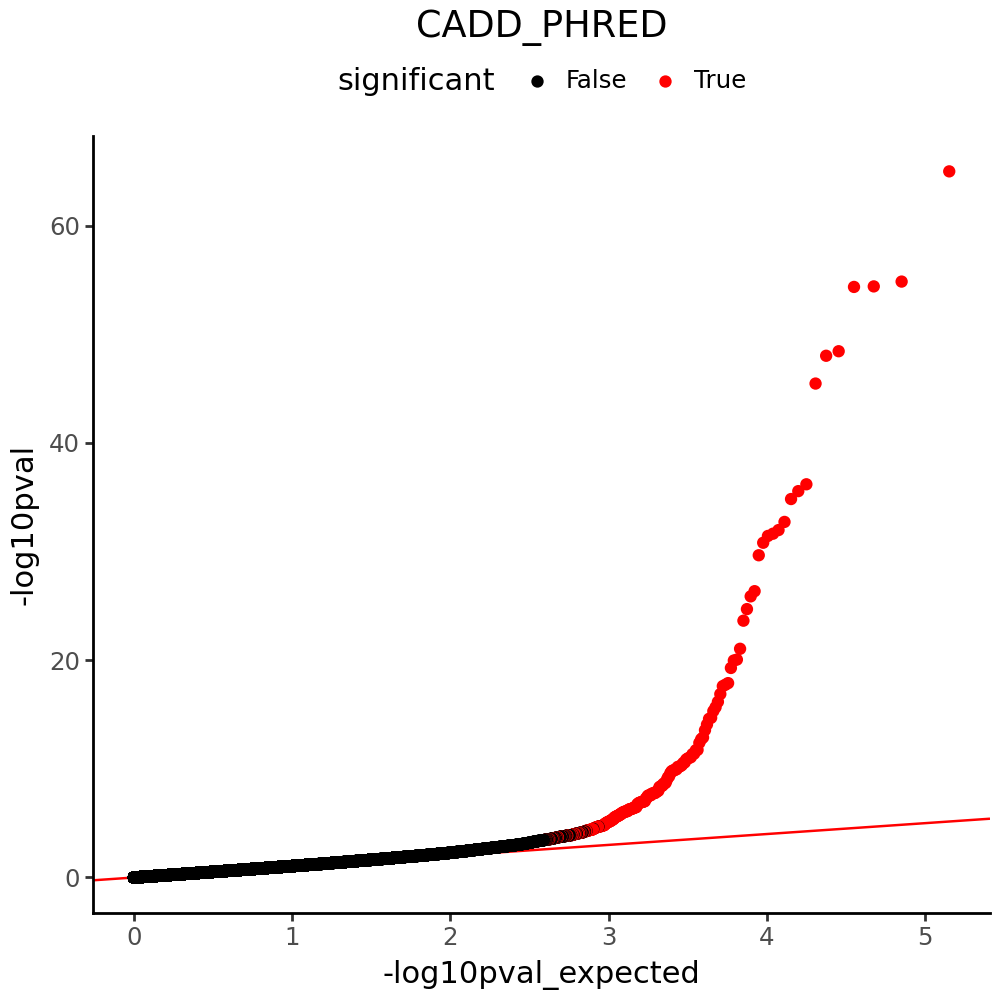

In [174]:
df_final=pd.read_csv('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/association/all_results_FDR_corrected.csv') 

QQ_plot_sig_egenes(df_final_filtered, \
                        "CADD_PHRED")


In [18]:
df_final_filtered =df_final[(~df_final["cell_type"].isin(["Erythrocytes", "Platelets"])) &
                                (df_final["burden_type"]!="GENE_TSS_DISTANCE")]
df_final_filtered.loc[df_final_filtered["burden_type"] == "DNA_LM_mixed", "burden_type"] = "DNA_LM_combined"


In [23]:
import plotnine as gg
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def _check_plotnine_grid(plots_list, figsize):
    if not isinstance(plots_list, list):
        raise ValueError('Input plots_list must be a list')
    if not (isinstance(figsize, tuple) and len(figsize) == 2):
        raise ValueError('Input figsize should be a tuple of length 2')

def plotnine_grid(plots_list, row=2, col=3, figsize=(12, 12)):
    _check_plotnine_grid(plots_list, figsize)

    fig, axes = plt.subplots(row, col, figsize=figsize)
    axes = axes.flatten()  # Flatten for easy indexing

    for ax, plot in zip(axes, plots_list):
        # Convert plotnine plot to matplotlib figure
        plot_fig = plot.draw()
        canvas = FigureCanvas(plot_fig)
        canvas.draw()

        # Convert figure to numpy array
        img_array = np.array(canvas.renderer.buffer_rgba())

        # Display in matplotlib subplot
        ax.imshow(img_array, aspect='auto')
        ax.axis('off')

    fig.tight_layout()
    return fig


def plotnine_grid2(plots_list, row=2, col=3, figsize=(30, 30)):
    _check_plotnine_grid(plots_list, figsize)

    fig, axes = plt.subplots(row, col, figsize=figsize)
    axes = axes.flatten()  # Flatten for easy indexing

    for ax, plot in zip(axes, plots_list):
        # Convert plotnine plot to matplotlib figure
        plot_fig = plot.draw()
        canvas = FigureCanvas(plot_fig)
        canvas.draw()

        # Convert figure to numpy array
        img_array = np.array(canvas.renderer.buffer_rgba())

        # Display in matplotlib subplot without stretching
        ax.imshow(img_array)
        ax.set_xticks([])  # Remove ticks
        ax.set_yticks([])
        ax.set_frame_on(False)

    fig.tight_layout()

    return fig


[2025-02-03 12:37:17,185] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[2025-02-03 12:37:20,605] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[2025-02-03 12:37:24,013] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[2025-02-03 12:37:27,517] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


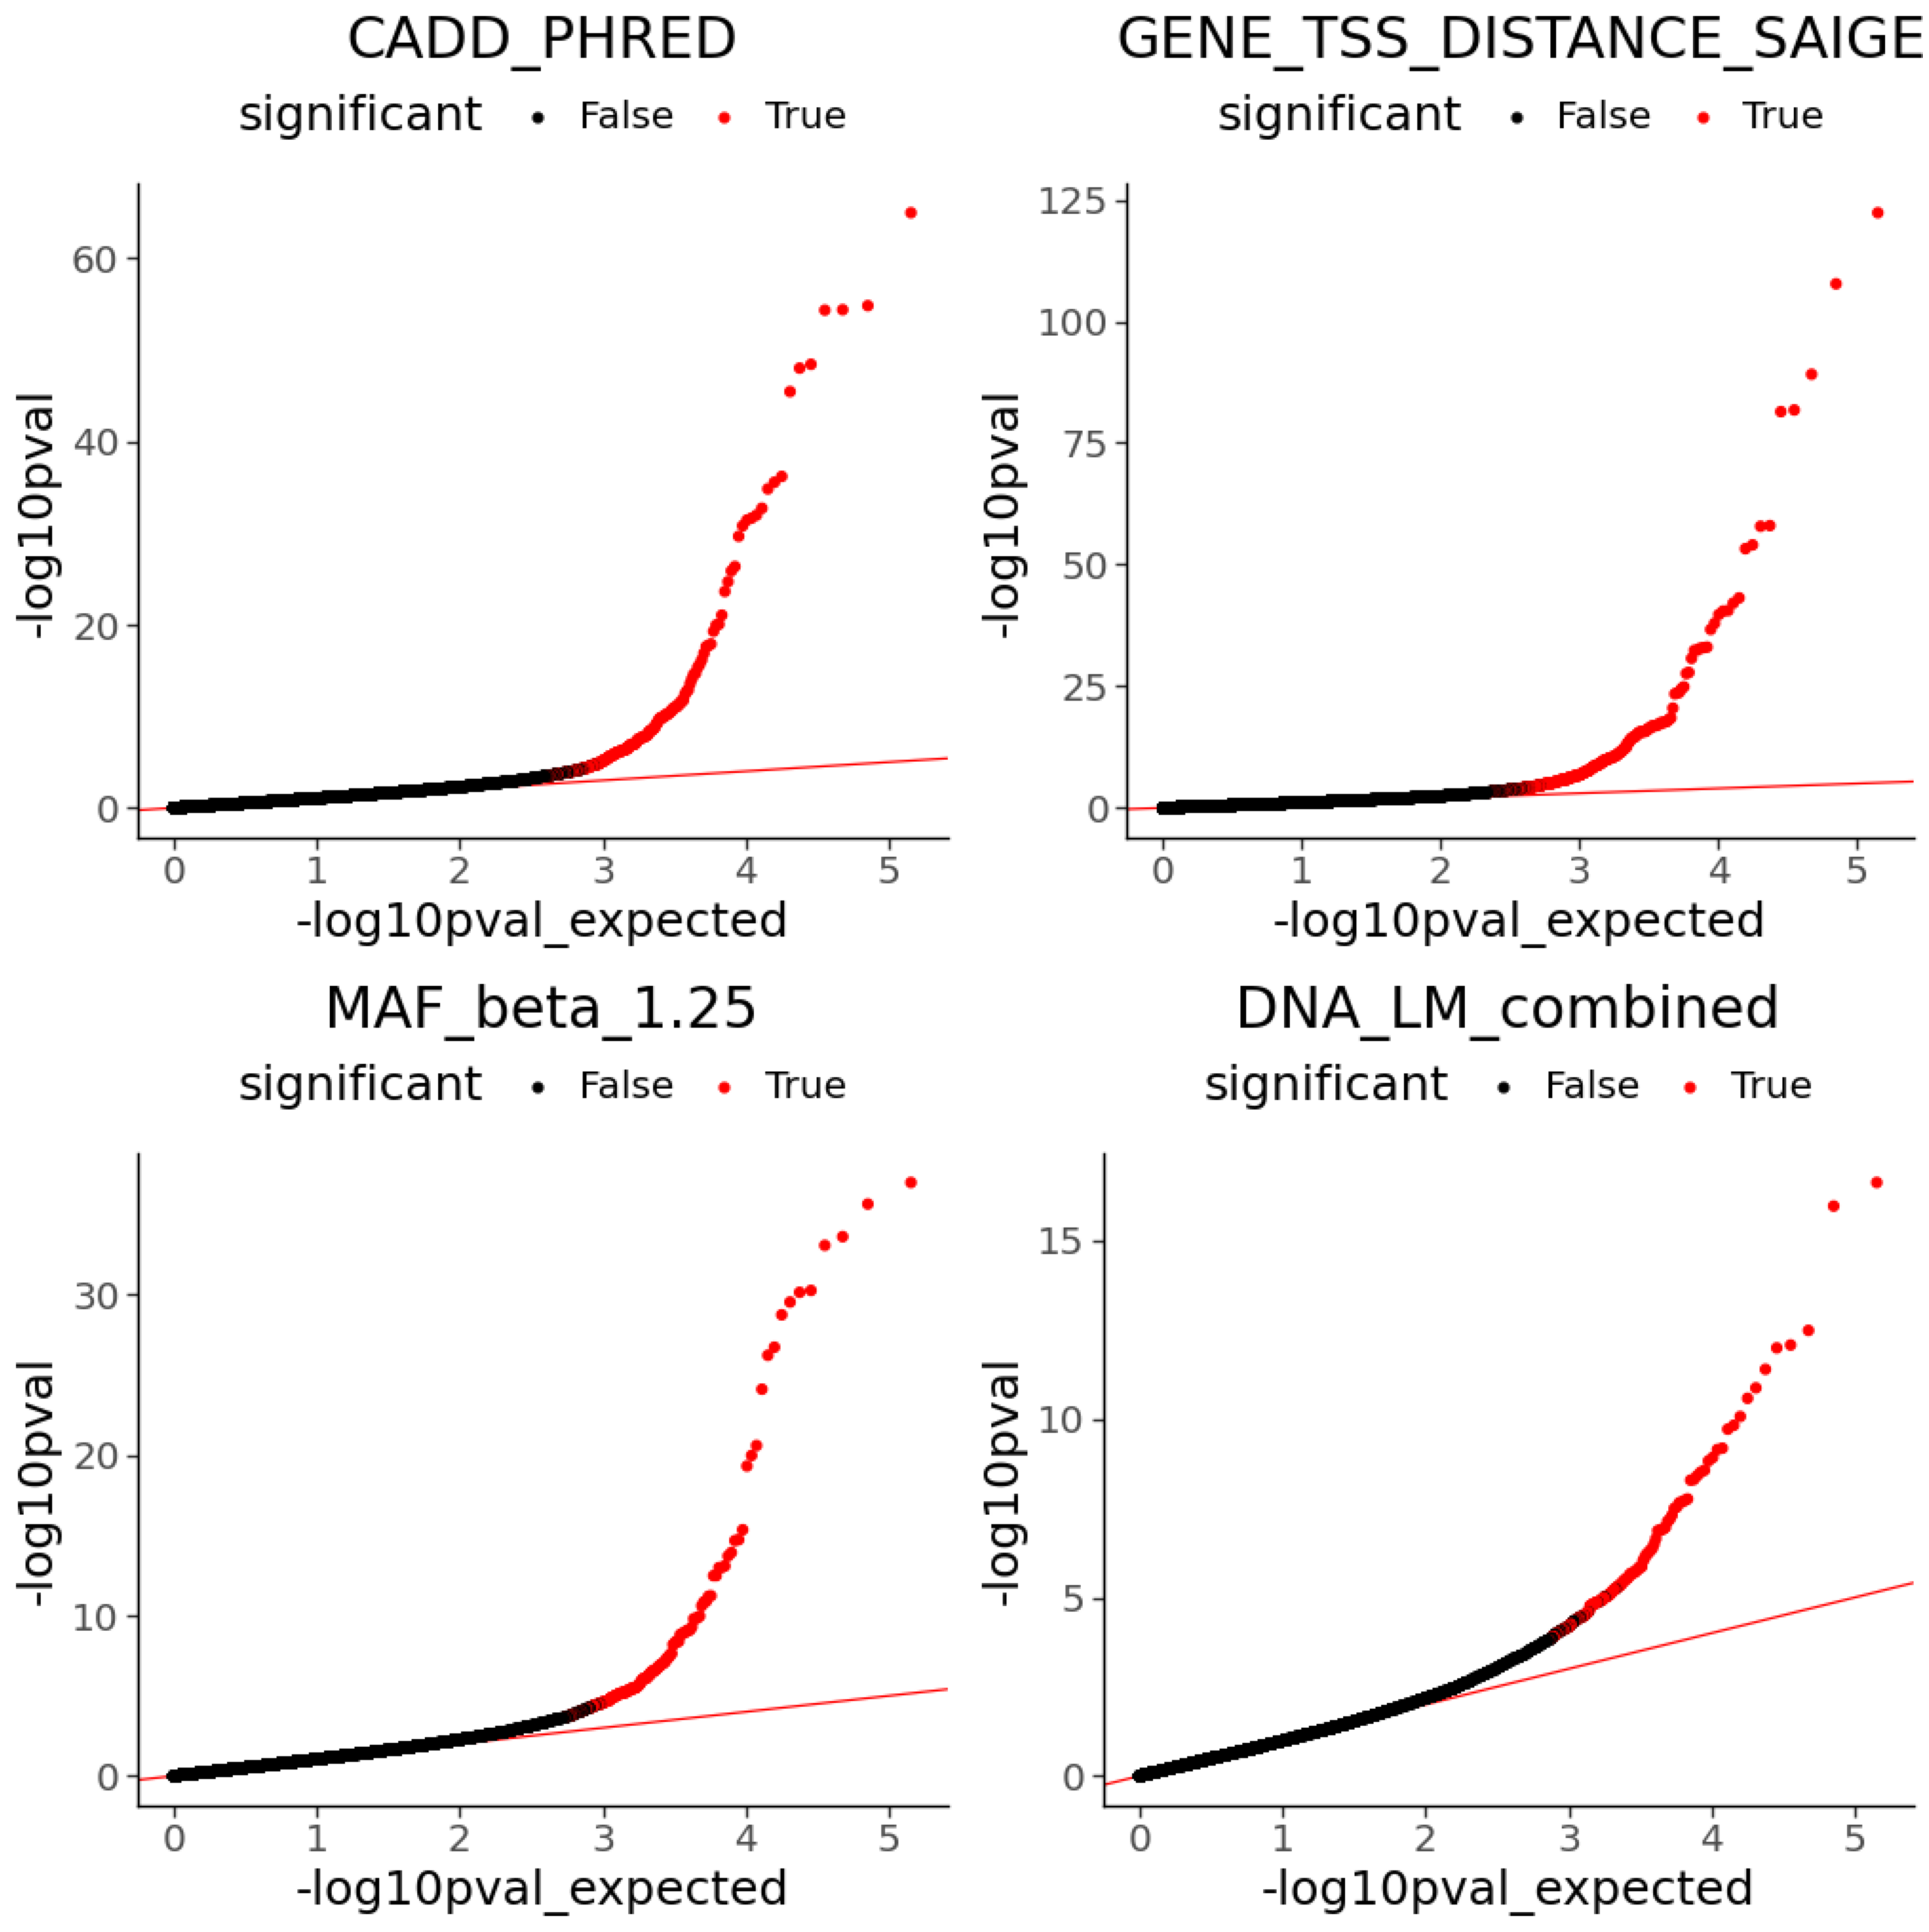

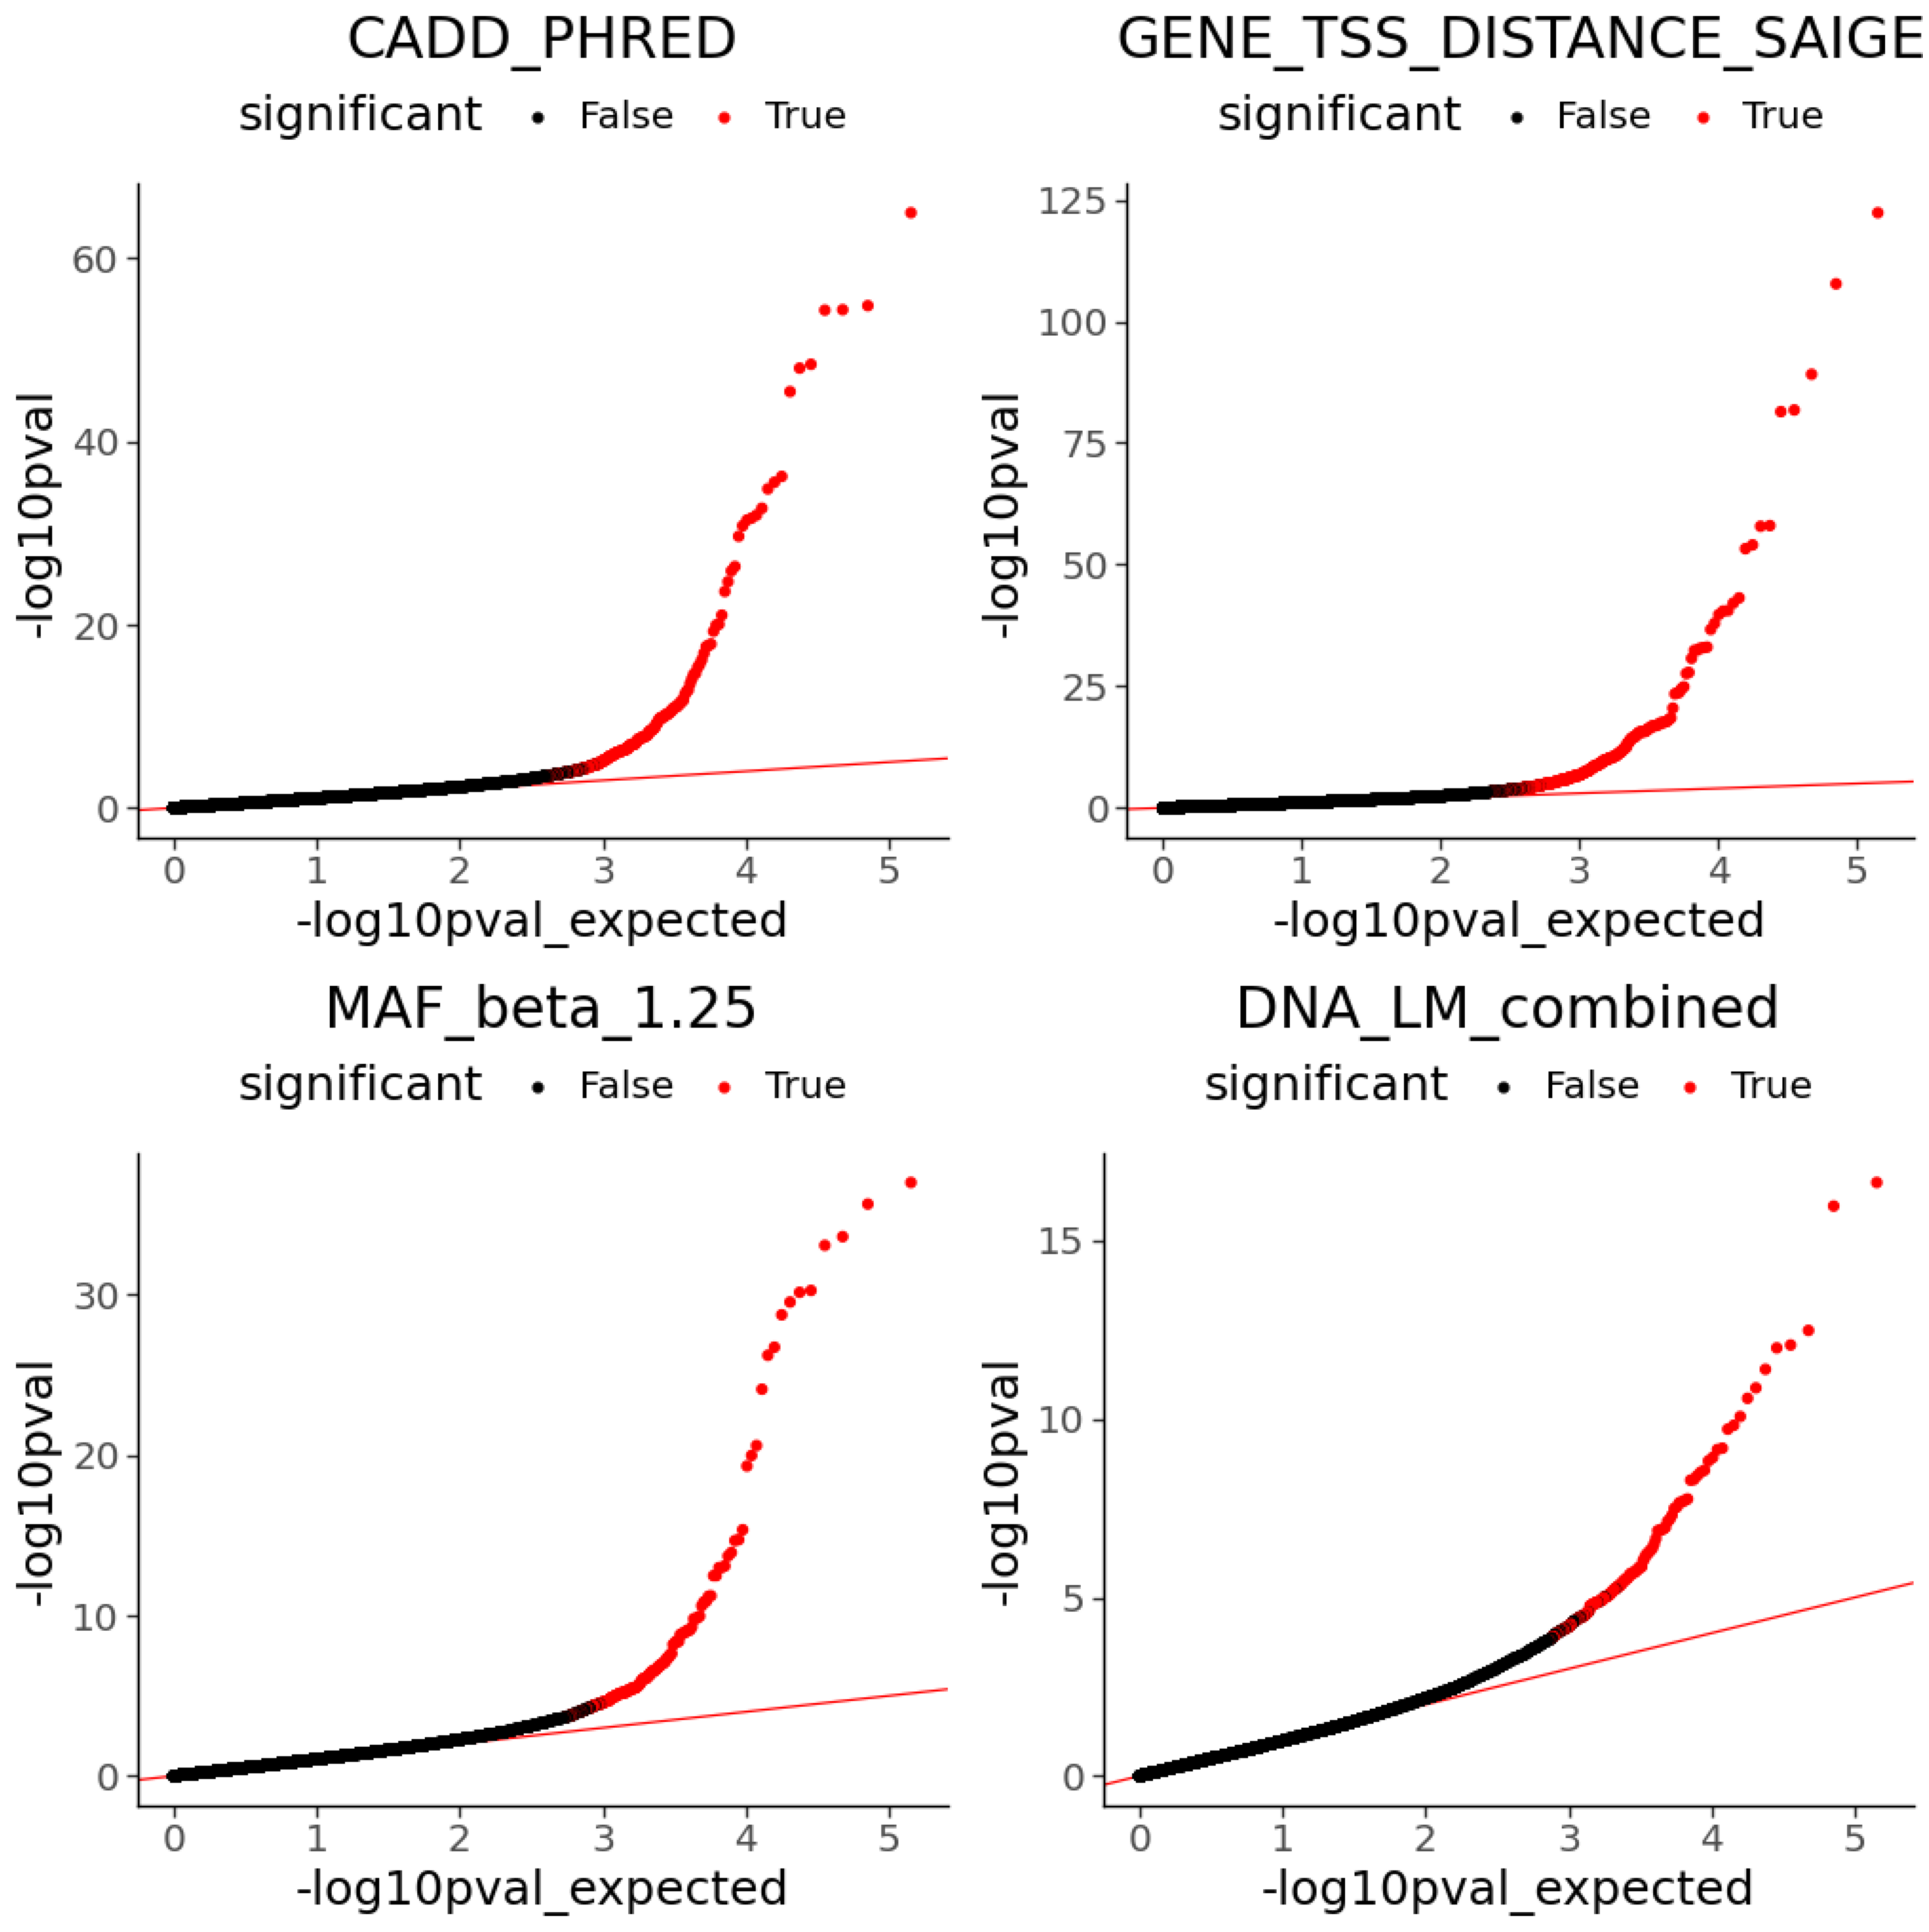

In [36]:
#plotnine_grid2([p1,p2, p3, p4, p5, p6])
plotnine_grid2([p1,p2, p3, p4], row=2, col=2, figsize=(30, 30))

[2025-01-30 19:10:17,663] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[2025-01-30 19:10:21,194] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[2025-01-30 19:10:24,745] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[2025-01-30 19:10:28,186] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[2025-01-30 19:10:31,685] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
[2025-01-30 19:10:35,154] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


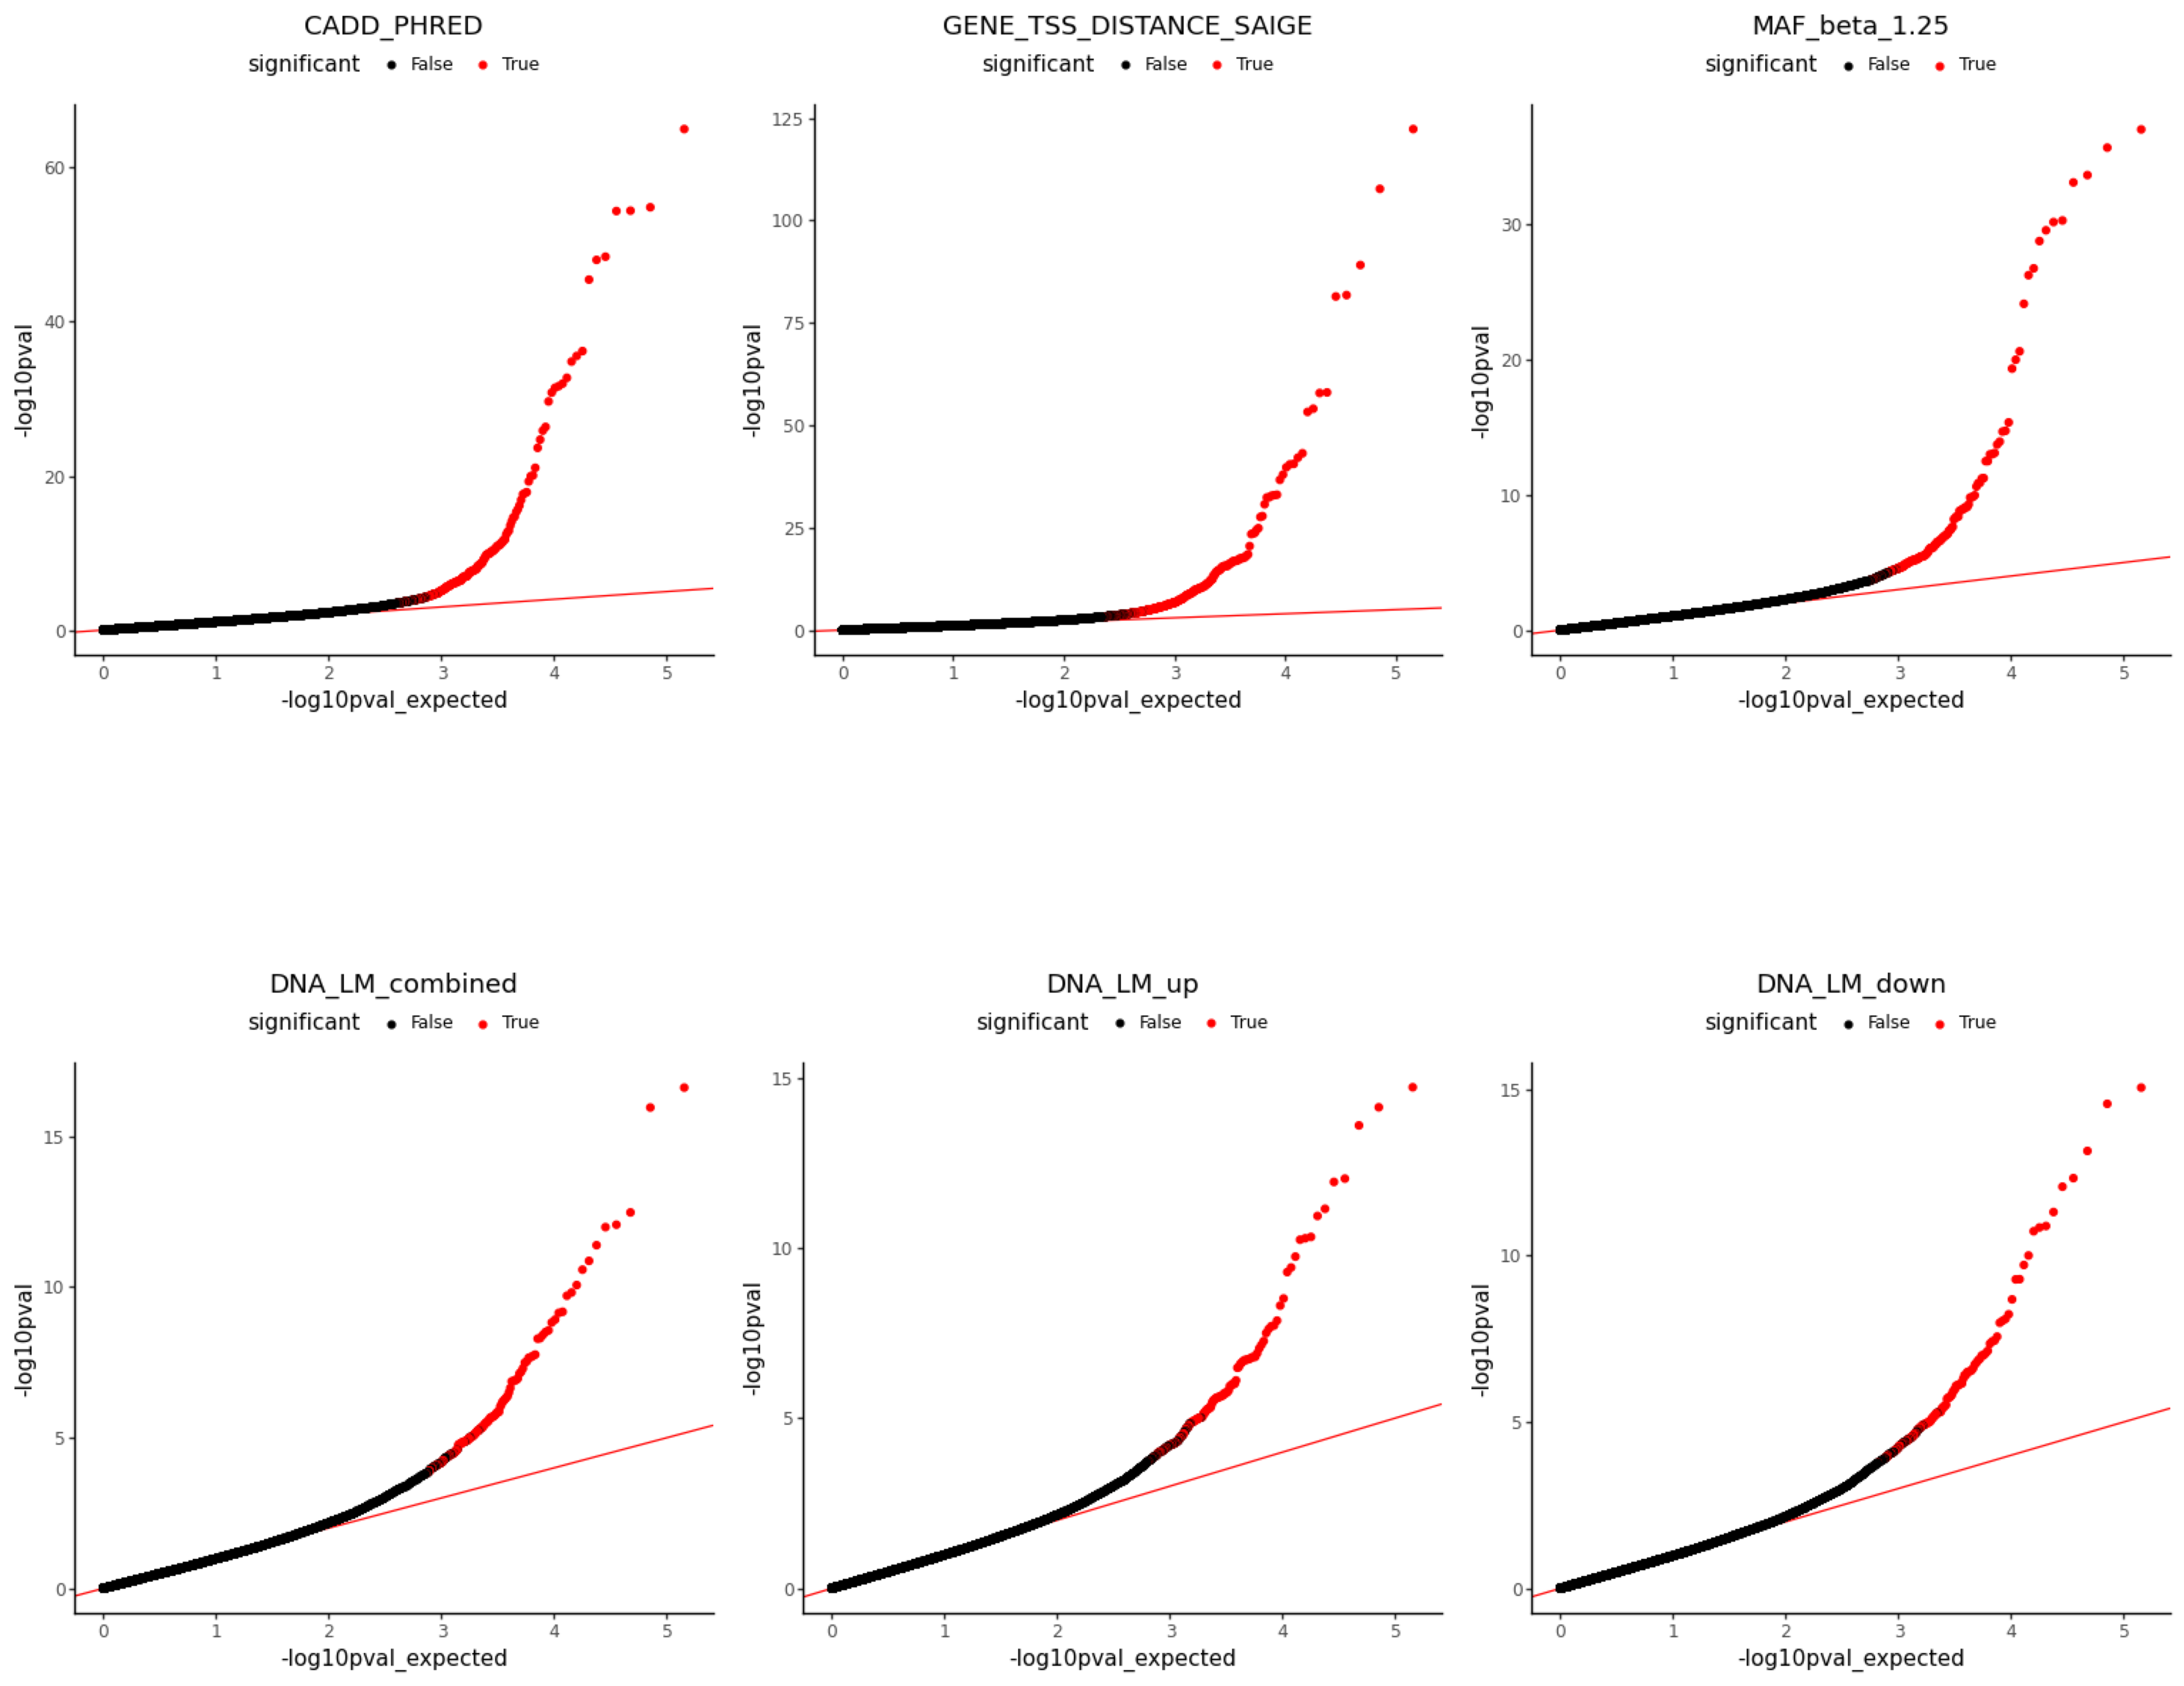

In [207]:
plotnine_grid2([p1,p2, p3, p4, p5, p6])

In [33]:
from plotnine import ggplot, aes, geom_point, labs, scale_color_manual, theme_classic, geom_abline, theme

p1=QQ_plot_sig_egenes(df_final_filtered, \
                        "CADD_PHRED")
p2=QQ_plot_sig_egenes(df_final_filtered, \
                        "GENE_TSS_DISTANCE_SAIGE")
p3=QQ_plot_sig_egenes(df_final_filtered, \
                        "MAF_beta_1.25")
p4=QQ_plot_sig_egenes(df_final_filtered, \
                        "DNA_LM_combined")
p5=QQ_plot_sig_egenes(df_final_filtered, \
                        "DNA_LM_up")
p6=QQ_plot_sig_egenes(df_final_filtered, \
                        "DNA_LM_down")

In [211]:
p1.save("QQ_CADD.png",  dpi=200)

/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 5 in image.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: QQ_CADD.png


[2025-01-30 19:14:21,318] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


In [212]:
p2.save("QQ_TSS.png",  dpi=200)
p3.save("QQ_MAF.png",  dpi=200)
p4.save("QQ_DNA_LM_c.png",  dpi=200)
p5.save("QQ_DNA_LM_u.png",  dpi=200)
p6.save("QQ_DNA_LM_d.png",  dpi=200)

/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 5 in image.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: QQ_TSS.png


[2025-01-30 19:14:47,427] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 5 in image.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: QQ_MAF.png


[2025-01-30 19:14:51,544] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 5 in image.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: QQ_DNA_LM_c.png


[2025-01-30 19:14:55,756] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 5 in image.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: QQ_DNA_LM_u.png


[2025-01-30 19:14:59,875] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 5 in image.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: QQ_DNA_LM_d.png


[2025-01-30 19:15:04,088] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
